# 파일 임포트 구글 드라이브 마운트 등


In [ ]:
pip install geopandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.6 MB/s 
     |████████████████████████████████| 16.6 MB 138 kB/s 
     |████████████████████████████████| 7.8 MB 45.4 MB/s 


In [ ]:
pip install pyshp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.7 MB/s 


In [ ]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.1 MB/s 
     |████████████████████████████████| 465 kB 50.9 MB/s 


In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 124015 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
#딥러닝 프레임워크
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from statsmodels.formula.api import ols

#전처리, 점수 측정
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#컴퓨터 리소스 할당 관련 
import os
from tqdm.auto import tqdm 

#기초 툴, 시각화
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.font_manager as fm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib
from yellowbrick.cluster import KElbowVisualizer

#기타
import warnings
warnings.filterwarnings("ignore")

#크롤링 및 워드클라우드
from bs4 import BeautifulSoup
import urllib.request
from urllib.parse import quote 
import requests
import re
from datetime import datetime
from PIL import *
from collections import Counter
import xml.etree.ElementTree as ET
import json
from konlpy.tag import *
from konlpy.tag import Twitter
from wordcloud import WordCloud

#지리
import geopandas as gpd
from geopy.geocoders import Nominatim
import shapefile
import folium
from shapely.geometry import Point, Polygon, LineString


In [ ]:
#구글 드라이브 mount
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [ ]:
#각종 경로
d_path="/content/gdrive/MyDrive/"
font_path = '/content/gdrive/MyDrive/DSF/malgun'


In [ ]:
#한글 폰트
font_name = fm.FontProperties(fname = font_path).get_name()
matplotlib.rc("font", family = font_name)
%matplotlib inline

# 장애인 예산 시각화

In [ ]:
#단위는 억 원
#자료출처: 보건복지부 기금운영계획안 사업운영계획
disabled_budget = [4679, 5221, 6061, 6907, 9685, 13057, 15070, 17405]
disabled_index = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
disabled_df = pd.DataFrame(disabled_budget, index=disabled_index, columns=["yearly_budget"])
disabled_df.head()

,yearly_budget
2015,4679
2016,5221
2017,6061
2018,6907
2019,9685


In [ ]:
disabled_list = [18816,
19652,
20670,
22213,
27326,
32762,
36662,
40070,

17101,
17755,
18744,
20155,
24731,
29840,
33447,
9731+20930+6541,
6931,
6911,
6927,
7306,
8495,
9180,
9664,
9731,

5496,
6130,
6973,
7902,
11065,
15107,
17704,
20930,

4673,
4715,
4845,
4947,
5171,
5553,
6079,
6541]

disabled_col = ["총계","3대 사업", "장애수당/연금", "장애인 선택적 복지", "장애인복지시설 지원"]

disabled_array = np.array(disabled_list)
disabled_array = disabled_array.reshape(5, -1)

disabled_whole = pd.DataFrame(disabled_array, index=disabled_col, columns=disabled_index)

disabled_whole = disabled_whole.T


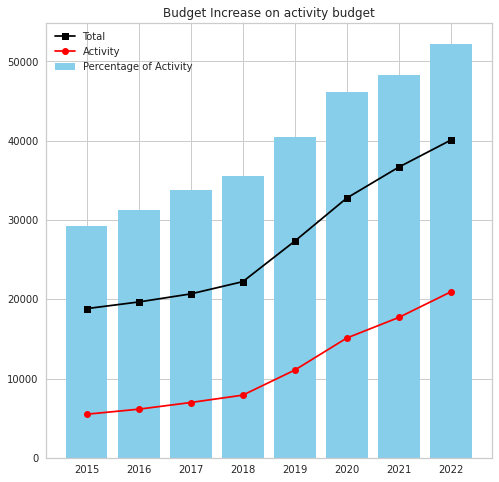

In [ ]:
#활동지원할당 예산 증가 추세/ 단위는 억 원
fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
ax.plot(disabled_whole.index, disabled_whole["총계"],marker='s', color="black", label='Total') 
ax.bar(disabled_whole.index, disabled_whole["장애인 선택적 복지"]*100*1000/disabled_whole["총계"], color="skyblue", label='Percentage of Activity') #10^3 scaled
ax.plot(disabled_whole.index, disabled_whole["장애인 선택적 복지"], color="red", marker='o',label='Activity') 
ax.legend()
plt.title("Budget Increase on activity budget")
plt.show()


#장애인을 수동적인 대상으로 바라보는 것이 아니라 장애인이 정책 시행의 주체로서 활동할 수 있게하는 것

# 크롤링, keyword = "탈시설"

In [ ]:
#탈시설 이라는 키워드 크롤링

news_url = 'https://search.naver.com/search.naver?where=news&sm=tab_jum&query={}'
query = "탈시설"
news_num =3000 # 총 필요한 뉴스의 개수
req = requests.get(news_url.format(query))
soup = BeautifulSoup(req.text, 'html.parser')

news_dict = {}
idx = 0
cur_page = 1


In [ ]:
while idx < news_num:
    
    table = soup.find('ul',{'class' : 'list_news'})
    li_list = table.find_all('li', {'id': re.compile('sp_nws.*')})
    area_list = [li.find('div', {'class' : 'news_area'}) for li in li_list]
    a_list = [area.find('a', {'class' : 'news_tit'}) for area in area_list]
    
    for n in a_list[:min(len(a_list), news_num-idx)]:
        news_dict[idx] = {'title' : n.get('title'),
                          'url' : n.get('href') }
        idx += 1

    cur_page += 1
    
    pages = soup.find('div', {'class' : 'sc_page_inner'})
    next_page_url = [p for p in pages.find_all('a') if p.text == str(cur_page)][0].get('href')
    
    req = requests.get('https://search.naver.com/search.naver' + next_page_url)
    soup = BeautifulSoup(req.text, 'html.parser')

In [ ]:
print('데이터프레임 변환')
news_df = pd.DataFrame(news_dict).T
news_df

데이터프레임 변환


,title,url
0,탈시설 뒤 반려자 만났다…‘2062명 승규씨’의 완전 자립을 위하여,https://www.hani.co.kr/arti/area/honam/1069703...
1,"전장연, 퇴근길 지하철 탑승 시위…4호선 운행 일부 지연",https://www.yna.co.kr/view/AKR2022120116940000...
2,최중증 발달장애 24시간 돌봄 추진…주간지원도 확대(종합),http://www.newsis.com/view/?id=NISX20221129_00...
3,진정한 탈시설 위해 필요한 권익옹호란,http://www.ablenews.co.kr/News/NewsContent.asp...
4,"30번째 세계장애인의날, 장애인 1200명 집결… ""탈시설은 선택 아닌 권리""",https://www.beminor.com/news/articleView.html?...
...,...,...
2995,"[포커스] 전장연 출근길 시위 '11개월째'…""절박함 이해""↔""방식 문제""",http://news.tvchosun.com/site/data/html_dir/20...
2996,"장애인 의원, 내년 장애인예산 증액 총력전",http://www.ablenews.co.kr/News/NewsContent.asp...
2997,장애인단체에서 사용하는 가족의 의미,http://www.ablenews.co.kr/News/NewsContent.asp...
2998,"인권위, 성락원 학대 피해자에 ""다른 시설로 가라"" 논란",https://www.beminor.com/news/articleView.html?...


In [ ]:
def word_list(title):
  noun_adj_list = []

  for words in title:
    sentence_list = twitter.pos(words)
    for word, tag in sentence_list:
      if tag in ["Noun", "Adjective"]:
        noun_adj_list.append(word)
      else:
        pass
  return noun_adj_list


In [ ]:
twitter = Twitter()
sentence_list = []


noun_adj = word_list(news_df["title"])
print(noun_adj)

    




['탈', '시설', '뒤', '반려자', '명', '승규', '의', '완전', '자립', '위', '장연', '퇴근길', '지하철', '탑승', '시위', '호선', '운행', '일부', '지연', '최', '증', '발달장애', '추진', '주간지', '확대', '종합', '진정한', '탈', '시설', '위해', '필요한', '권익', '옹호', '란', '세계', '장애인', '날', '장애인', '명', '집결', '탈시', '선택', '아닌', '권리', '장애인', '독립', '기반', '자립', '생활', '주택', '예산', '문제', '미래', '불안해', '아이', '세상', '변화', '장애인', '부모', '일', '정의당', '장애인', '권리', '보편', '보장', '위해', '장애인', '리보', '장법', '제정', '김도현', '장애', '학', '김도현', '도전', '김원영', '투쟁', '결과', '장애인', '권리', '예산', '열매', '장연', '시위', '장애인', '예산', '증액', '박희', '율', '광주시', '의원', '장애인', '탈', '시설', '지원', '조례', '발의', '탈', '시설', '시범', '사업', '속', '장애인', '고립', '대안', '시급', '서평', '탈', '시설', '외국인', '보호', '폐지', '동물', '해방', '교차로', '정', '박희', '율', '의원', '광주', '광역시', '장애인', '탈', '시설', '및', '지역', '사회', '정착', '지원', '조례', '대표', '발의', '탈', '시설', '발달장애', '세상', '밖', '연극', '등장인물', '신체', '장애', '정신장애', '운동', '연대', '목소리', '투쟁', '결', '의문', '마흔', '살이', '학교', '가지', '이상근', '전문', '유엔', '장애인', '권리', '위원회', '탈', '시설', '가이드라인', '시설', '수용', '복지', 

In [ ]:
counts = Counter(noun_adj)
tags = counts.most_common(50)
print(tags)

[('시설', 2487), ('탈', 2131), ('장애인', 1728), ('지원', 633), ('자립', 334), ('정책', 286), ('장연', 280), ('시위', 219), ('권리', 199), ('장애', 195), ('지하철', 190), ('서울시', 177), ('촉구', 158), ('발달장애', 157), ('자립생활', 156), ('예산', 149), ('호선', 147), ('보장', 144), ('법', 140), ('사회', 136), ('단체', 126), ('제정', 120), ('정부', 115), ('위', 113), ('거주', 113), ('지역', 107), ('사업', 104), ('조례', 99), ('복지', 99), ('개최', 98), ('부모', 95), ('투쟁', 91), ('인권', 90), ('로드맵', 89), ('포토', 89), ('추진', 84), ('인천', 84), ('대구', 81), ('대구시', 78), ('중', 72), ('계획', 72), ('희망', 72), ('애인', 69), ('서울', 65), ('것', 64), ('요구', 63), ('명', 62), ('회', 62), ('약속', 62), ('출근길', 60)]


In [ ]:
#전장연 시위 관련된 단어, '장애'같은 동의어는 수작업으로 제거 
tags_dict = dict(tags)
#print(tags_dict.keys())
execute_keys = ["시설", "탈", "장연", "지하철", "탈시", "위", "시위", "중", "것"] 

useful_dict = {}
for key in tags_dict:
  if key not in execute_keys:
    useful_dict[key] = tags_dict[key]
  
print(useful_dict)

{'장애인': 1728, '지원': 633, '자립': 334, '정책': 286, '권리': 199, '장애': 195, '서울시': 177, '촉구': 158, '발달장애': 157, '자립생활': 156, '예산': 149, '호선': 147, '보장': 144, '법': 140, '사회': 136, '단체': 126, '제정': 120, '정부': 115, '거주': 113, '지역': 107, '사업': 104, '조례': 99, '복지': 99, '개최': 98, '부모': 95, '투쟁': 91, '인권': 90, '로드맵': 89, '포토': 89, '추진': 84, '인천': 84, '대구': 81, '대구시': 78, '계획': 72, '희망': 72, '애인': 69, '서울': 65, '요구': 63, '명': 62, '회': 62, '약속': 62, '출근길': 60}


In [ ]:
wordcloud = WordCloud(
    font_path = '/content/gdrive/MyDrive/DSF/malgun', background_color='white', colormap='Reds').generate_from_frequencies(useful_dict)

Text(0.5, 1.0, 'Wordcloud')

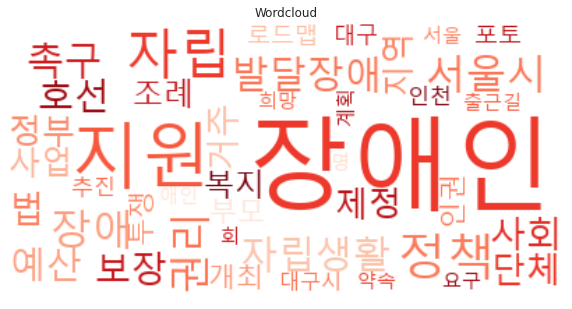

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off') 
plt.title("Wordcloud")


# 예산 -> 활동지원사 수 회귀분석

In [ ]:
import requests

url = 'http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api'
params = {'serviceKey' : 'P17GWD3PsEYIjlKLQZhHbDp7%2FB6PK0nyG2uYMfazEiD%2BTAeBwMc6HdvyA7UBWxpt0uBzAOGSrmCNcco7E0bc%2FA%3D%3D', 'pageNo' : '1', 'numOfRows' : '10', 'apiType' : 'XML', 'year' : '2019', 'dvsd' : '인천' }

response = requests.get(url, params=params)
print(response.content)


b'<OpenAPI_ServiceResponse>\n\t<cmmMsgHeader>\n\t\t<errMsg>SERVICE ERROR</errMsg>\n\t\t<returnAuthMsg>SERVICE_KEY_IS_NOT_REGISTERED_ERROR</returnAuthMsg>\n\t\t<returnReasonCode>30</returnReasonCode>\n\t</cmmMsgHeader>\n</OpenAPI_ServiceResponse>'


In [ ]:
encoding = "P17GWD3PsEYIjlKLQZhHbDp7%2FB6PK0nyG2uYMfazEiD%2BTAeBwMc6HdvyA7UBWxpt0uBzAOGSrmCNcco7E0bc%2FA%3D%3D"
year=""
region=""
def make_url(encoding, year, region):
  

  url = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + str(encoding) + "numOfRows=20&pageNo=1&apiType=JSON&year="+str(year)+"&dvsd="+str(region)
  return url



In [ ]:
url_2015 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2015&dvsd=인천"
url_2016 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2016"

url_2017 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2017"
url_2018 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2018"
url_2019 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2019"
url_2020 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2020"
url_2021 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2021"
url_2022 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2022"

url_list = [url_2015, url_2016, url_2017, url_2018, url_2019, url_2020, url_2021, url_2022]



In [ ]:
req = requests.get(url_2018)
req.encoding = "utf-8"
text = req.content
print(text)

b'{"pageNo":"1","resultCode":"00","totalCount":51,"items":[{"emsfsFml":"null","acvspMale":"null","acvspTtl":"740","year":"2018","emsfsMale":"null","emsfsTtl":"758","acvspFml":"null","dvsd":"\xea\xb4\x91\xec\xa3\xbc"},{"emsfsFml":"null","acvspMale":"null","acvspTtl":"161","year":"2018","emsfsMale":"null","emsfsTtl":"209","acvspFml":"null","dvsd":"\xec\x9a\xb8\xec\x82\xb0"},{"emsfsFml":"null","acvspMale":"null","acvspTtl":"146","year":"2018","emsfsMale":"null","emsfsTtl":"355","acvspFml":"null","dvsd":"\xec\xa0\x9c\xec\xa3\xbc"},{"emsfsFml":"null","acvspMale":"null","acvspTtl":"1388","year":"2018","emsfsMale":"null","emsfsTtl":"1107","acvspFml":"null","dvsd":"\xeb\xb6\x80\xec\x82\xb0"},{"emsfsFml":"null","acvspMale":"null","acvspTtl":"631","year":"2018","emsfsMale":"null","emsfsTtl":"456","acvspFml":"null","dvsd":"\xec\xa0\x84\xeb\xb6\x81"},{"emsfsFml":"null","acvspMale":"null","acvspTtl":"849","year":"2018","emsfsMale":"null","emsfsTtl":"353","acvspFml":"null","dvsd":"\xea\xb2\xbd\xeb\x

In [ ]:
act_dict = {}
ems_dict = {}
n = 0
req = requests.get(url_2015)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems
print(ems_dict)

{'year_2015': 0}


In [ ]:
n = 1
req = requests.get(url_2016)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems

print(act_dict)


{'year_2015': 0, 'year_2016': 0}


In [ ]:
n = 2
req = requests.get(url_2017)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems

print(act_dict)

{'year_2015': 0, 'year_2016': 0, 'year_2017': 12871}


In [ ]:
n = 3
req = requests.get(url_2018)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems

print(act_dict)

{'year_2015': 0, 'year_2016': 0, 'year_2017': 12871, 'year_2018': 14783}


In [ ]:
n = 4
req = requests.get(url_2019)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems

print(act_dict)

{'year_2015': 0, 'year_2016': 0, 'year_2017': 12871, 'year_2018': 14783, 'year_2019': 15897}


In [ ]:
n = 5
req = requests.get(url_2020)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems

print(act_dict)

{'year_2015': 0, 'year_2016': 0, 'year_2017': 12871, 'year_2018': 14783, 'year_2019': 15897, 'year_2020': 0}


In [ ]:
n = 6
req = requests.get(url_2021)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems


print(act_dict)

{'year_2015': 0, 'year_2016': 0, 'year_2017': 12871, 'year_2018': 14783, 'year_2019': 15897, 'year_2020': 0, 'year_2021': 0}


In [ ]:
act_dict["year_2022"] = 0
ems_dict["year_2022"] = 0

In [ ]:
disabled_df["yearly_act"] = act_dict.values()
disabled_df["yearly_ems"] = ems_dict.values()
disabled_df_real = disabled_df[2:5]
disabled_df_real

,yearly_budget,yearly_act,yearly_ems
2017,6061,12871,9228
2018,6907,14783,9752
2019,9685,15897,9567


In [ ]:
ols("yearly_act~yearly_budget", data = disabled_df_real).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             yearly_act   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     4.292
Date:                Tue, 06 Dec 2022   Prob (F-statistic):              0.286
Time:                        13:04:57   Log-Likelihood:                -23.149
No. Observations:                   3   AIC:                             50.30
Df Residuals:                       1   BIC:                             48.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9027.5236   2704.697      3.338      0.185   -2.53e+04    4.34e+04
yearly_budget     0.7270      0.351      2.072      0.286      -3.732       5.186
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.827
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.379
Skew:                           0.442   Prob(JB):                        0.827
Kurtosis:                       1.500   Cond. No.                     3.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
b_1 = 0.7270 
b_0 = 9027.5236 

def money_to_people(x):
  return b_0 + b_1 * x

disabled_df_real["yearly_budget"].apply(lambda x: money_to_people(x))

2017    13433.8706
2018    14048.9126
2019    16068.5186
Name: yearly_budget, dtype: float64

# 자치구내 법정동별 인구 

In [ ]:
people = pd.read_csv(d_path + "행정안전부_지역별(법정동) 성별 연령별 주민등록 인구수_20221031.csv", header=0, encoding="cp949")
people.head()

,법정동코드,기준연월,시도명,시군구명,읍면동명,리명,계,남자,여자,만0세남자,...,만101세여자,만102세여자,만103세여자,만104세여자,만105세여자,만106세여자,만107세여자,만108세여자,만109세여자,만110세이상여자
0,1111010100,2022-10-31,서울특별시,종로구,청운동,청운동,2339,1168,1171,5,...,1,0,0,0,0,0,0,0,0,0
1,1111010200,2022-10-31,서울특별시,종로구,신교동,신교동,1381,618,763,1,...,0,0,0,0,0,0,0,0,0,0
2,1111010300,2022-10-31,서울특별시,종로구,궁정동,궁정동,199,84,115,0,...,0,0,0,0,0,0,0,0,0,0
3,1111010400,2022-10-31,서울특별시,종로구,효자동,효자동,569,251,318,1,...,0,0,0,0,0,0,0,0,0,0
4,1111010500,2022-10-31,서울특별시,종로구,창성동,창성동,436,181,255,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#자료 설명

'''
법정동(읍면동리) 성별 연령별 주민등록 인구에 대한 데이터입니다.
법정동은 시 또는 구의 하위 행정구역으로 법률로 지정한 구역을 말합니다.
https://www.data.go.kr/data/15099158/fileData.do
'''

'\n법정동(읍면동리) 성별 연령별 주민등록 인구에 대한 데이터입니다.\n법정동은 시 또는 구의 하위 행정구역으로 법률로 지정한 구역을 말합니다.\nhttps://www.data.go.kr/data/15099158/fileData.do\n'

In [ ]:
#2022년 10월 기준

people = pd.read_csv(d_path + "행정안전부_지역별(법정동) 성별 연령별 주민등록 인구수_20221031.csv", header=0, encoding="cp949")
people = people.iloc[:, :7]
people = people[people["시도명"] == "서울특별시"]
people.drop(["시도명", "기준연월", "리명"], axis = 1, inplace = True)  

In [ ]:
people
#구, 동 별 인구

,법정동코드,시군구명,읍면동명,계
0,1111010100,종로구,청운동,2339
1,1111010200,종로구,신교동,1381
2,1111010300,종로구,궁정동,199
3,1111010400,종로구,효자동,569
4,1111010500,종로구,창성동,436
...,...,...,...,...
452,1174010600,강동구,둔촌동,24281
453,1174010700,강동구,암사동,66516
454,1174010800,강동구,성내동,65754
455,1174010900,강동구,천호동,85838


# 클러스터 정하기 (pt.0)

In [ ]:
sh_geo_pre = gpd.read_file(d_path + "house/a.shp")
geo_gu = pd.read_csv(d_path+"gu.csv", encoding="cp949")
geo_gu.rename(columns= {"주소": "field1"}, inplace=True)
merge_outer = pd.merge(geo_gu, sh_geo_pre, how="outer", on="field1")
saved_outer = merge_outer.loc[:, ["자치구", "field1", "geometry"]] 
saved_outer.dropna(axis=0, inplace=True)
geo_center = gpd.GeoDataFrame(saved_outer, geometry="geometry")
geo_center.head()


,자치구,field1,geometry
0,노원구,섬밭로 201 하계동 시영아파트,POINT (127.06629 37.63309)
1,마포구,월드컵로 207 성산동 도시개발공사성산아파트,POINT (126.90148 37.56462)
2,중랑구,용마산로 228 면목동 도시개발아파트,POINT (127.08841 37.57357)
3,노원구,노원로19길 31 중계동 목화아파트,POINT (127.07005 37.64257)
4,노원구,노원로 331 중계동 시영3단지목련아파트,POINT (127.06881 37.64593)


In [ ]:
empty_cell = np.zeros(670*2)
empty_cell = empty_cell.reshape(-1, 2)
empty_df = pd.DataFrame(empty_cell, columns = ["x", "y"])
geo_center = pd.concat([geo_center, empty_df], axis=1)
geo_center.head()

,자치구,field1,geometry,x,y
0,노원구,섬밭로 201 하계동 시영아파트,POINT (127.06629 37.63309),0.0,0.0
1,마포구,월드컵로 207 성산동 도시개발공사성산아파트,POINT (126.90148 37.56462),0.0,0.0
2,중랑구,용마산로 228 면목동 도시개발아파트,POINT (127.08841 37.57357),0.0,0.0
3,노원구,노원로19길 31 중계동 목화아파트,POINT (127.07005 37.64257),0.0,0.0
4,노원구,노원로 331 중계동 시영3단지목련아파트,POINT (127.06881 37.64593),0.0,0.0


In [ ]:
#서울시  boundary 및 구별 boundary

"https://www.data.go.kr/data/15099541/fileData.do"
seoul_geo = gpd.GeoDataFrame.from_file(d_path + "seoul/LARD_ADM_SECT_SGG_11.shp", encoding="cp949")


# 클러스터 정하기 (pt. 1)


In [ ]:
def bring_xy(df, idx):
  ar = df["geometry"]

  ar2 = ar[idx].xy
  x = ar2[0][0]
  y = ar2[1][0]
  return x, y



In [ ]:
i = 1
for i in range(geo_center.shape[0]-1):
  try: 
    a = bring_xy(geo_center, i)
    geo_center.iloc[i, 3] = a[0]
    geo_center.iloc[i, 4] = a[1]

  except:
    print("error passed!")
    pass
  


error passed!
error passed!
error passed!
error passed!
error passed!
error passed!
error passed!
error passed!
error passed!
error passed!
error passed!


In [ ]:
geo_center = geo_center[geo_center["x"]!=0]
geo_center

,자치구,field1,geometry,x,y
0,노원구,섬밭로 201 하계동 시영아파트,POINT (127.06629 37.63309),127.066294,37.633086
1,마포구,월드컵로 207 성산동 도시개발공사성산아파트,POINT (126.90148 37.56462),126.901477,37.564623
2,중랑구,용마산로 228 면목동 도시개발아파트,POINT (127.08841 37.57357),127.088409,37.573566
3,노원구,노원로19길 31 중계동 목화아파트,POINT (127.07005 37.64257),127.070051,37.642573
4,노원구,노원로 331 중계동 시영3단지목련아파트,POINT (127.06881 37.64593),127.068807,37.645926
...,...,...,...,...,...
664,성북구,숭인로8길 80길음동 508-16,POINT (127.02694 37.60837),127.026939,37.608369
665,광진구,광나루로 20길 34화양동 111-89,POINT (127.07395 37.54560),127.073950,37.545603
666,마포구,토정로 131상수동 355-2,POINT (126.95720 36.87221),126.957202,36.872210
667,강서구,강서로 231화곡동 1170,POINT (126.83597 37.54626),126.835970,37.546261


In [ ]:
#스케일링
"""
scaler_x = StandardScaler()
before_scale_x = geo_center[["x"]]
after_scale_x = scaler_x.fit_transform(before_scale_x)
geo_center["x"] = after_scale_x


scaler_y = StandardScaler()
before_scale_y = geo_center[["y"]]
after_scale_y = scaler_y.fit_transform(before_scale_y)
geo_center["y"] = after_scale_y
geo_center.head()
"""

'\nscaler_x = StandardScaler()\nbefore_scale_x = geo_center[["x"]]\nafter_scale_x = scaler_x.fit_transform(before_scale_x)\ngeo_center["x"] = after_scale_x\n\n\nscaler_y = StandardScaler()\nbefore_scale_y = geo_center[["y"]]\nafter_scale_y = scaler_y.fit_transform(before_scale_y)\ngeo_center["y"] = after_scale_y\ngeo_center.head()\n'

In [ ]:
#서울시 아닌 거 제거.
geo_center = geo_center[geo_center["자치구"] != "의정부시"]

In [ ]:
gu_count = geo_center.groupby("자치구").count()
gu_count = gu_count.sort_values(by=["field1"], ascending=False)

gu_count.head()

,field1,geometry,x,y
자치구,,,,
은평구,57,57,57,57
강서구,47,47,47,47
성북구,43,43,43,43
마포구,42,42,42,42
서초구,40,40,40,40


In [ ]:
def visual_xy(df, gu):
  spec_gu = df[df['자치구'] == gu]
  plt.scatter(spec_gu["x"], spec_gu["y"])
  plt.title(gu)
  plt.show()

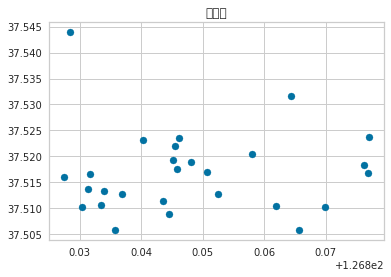

In [ ]:
visual_xy(geo_center, "양천구")

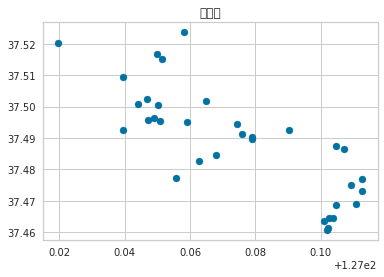

In [ ]:
visual_xy(geo_center, "강남구")

# 클러스터 정하기(pt. 2)


In [ ]:
gu_count

,field1,geometry,x,y
자치구,,,,
은평구,57,57,57,57
강서구,47,47,47,47
성북구,43,43,43,43
마포구,42,42,42,42
서초구,40,40,40,40
강동구,39,39,39,39
동대문구,38,38,38,38
강남구,34,34,34,34
성동구,32,32,32,32


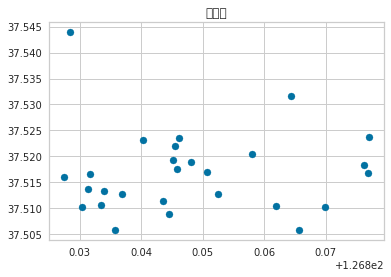

In [ ]:
visual_xy(geo_center, "양천구")

In [ ]:
geo_center.shape

(656, 5)

In [ ]:
#클러스터 변수 만들기

zero_array = np.zeros(656*1).reshape(-1, 1)
geo_center["cluster"] = zero_array
geo_center.head()
"""
xys = geo_center[geo_center["자치구"]=="양천구"][["x", "y"]]
model = KMeans(n_clusters = 3, random_state = 156)
model.fit(xys)
geo_center.loc[geo_center["자치구"] == "양천구", "cluster"] = model.fit_predict(xys)
geo_center[geo_center["자치구"] == "양천구"]
"""

'\nxys = geo_center[geo_center["자치구"]=="양천구"][["x", "y"]]\nmodel = KMeans(n_clusters = 3, random_state = 156)\nmodel.fit(xys)\ngeo_center.loc[geo_center["자치구"] == "양천구", "cluster"] = model.fit_predict(xys)\ngeo_center[geo_center["자치구"] == "양천구"]\n'

In [ ]:
"""
i=1
spec_gu = geo_center[geo_center["자치구"]=="양천구"]
spec_gu
spec_gu.loc[spec_gu["cluster"] ==i, "x"]

#plt.scatter(geo_center.loc[geo_center["자치구"] == "양천구", "x"], geo_center.loc[geo_center["자치구"] == "양천구", "y"], label = "cluster" +str(i))
"""
geo_center.head()

,자치구,field1,geometry,x,y,cluster
0,노원구,섬밭로 201 하계동 시영아파트,POINT (127.06629 37.63309),127.066294,37.633086,0.0
1,마포구,월드컵로 207 성산동 도시개발공사성산아파트,POINT (126.90148 37.56462),126.901477,37.564623,0.0
2,중랑구,용마산로 228 면목동 도시개발아파트,POINT (127.08841 37.57357),127.088409,37.573566,0.0
3,노원구,노원로19길 31 중계동 목화아파트,POINT (127.07005 37.64257),127.070051,37.642573,0.0
4,노원구,노원로 331 중계동 시영3단지목련아파트,POINT (127.06881 37.64593),127.068807,37.645926,0.0


In [ ]:
def make_cluster(df, k, gu, visualize = False, elbow = True):
  spec_gu = df[df["자치구"] == gu]
  xys = spec_gu[["x", "y"]]

  model = KMeans(n_clusters = k, random_state = 10)
  model.fit(xys)
  df.loc[df["자치구"] == gu, "cluster"] = model.fit_predict(xys)
  cluster_center = model.cluster_centers_

  
  if visualize:
    plt.figure(figsize = (8, 8))
    for i in range(k):
      
      plt.scatter(spec_gu.loc[spec_gu["cluster"] == i, "x" ], spec_gu.loc[spec_gu["cluster"] == i, "y"], label = "cluster"+str(i))
    plt.legend()
    plt.title("K = %d results" %k, size = 15)
    plt.xlabel("x", size = 6)
    plt.ylabel("y" , size = 6)
    plt.show()

    if elbow:
      visualizer = KElbowVisualizer(model, k = (1, 10))
      visualizer.fit(xys)

      return df, cluster_center


    else:
      print("elbow 없이 visualizing을 어떻게 합니까..")
      
      return df, cluster_center
      

  else:
    if elbow:
      visualizer = KElbowVisualizer(model, k =(1, 10))
      visualizer.fit(xys)

      return df, cluster_center





    else: 

      return df, cluster_center


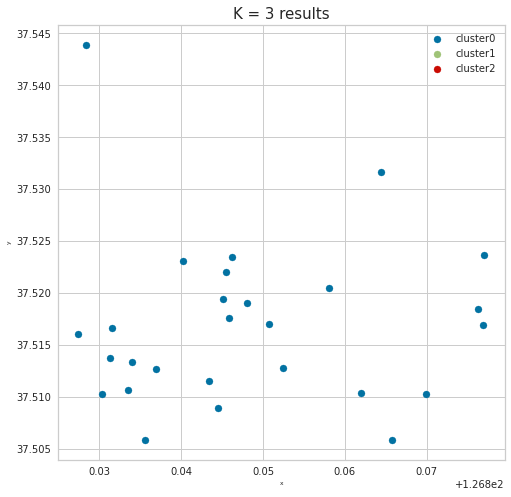

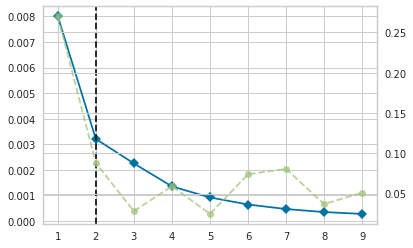

In [ ]:
new_df , center = make_cluster(geo_center, 3, "양천구", visualize = True, elbow = True)

In [ ]:
center

array([[126.83214743,  37.51589303],
       [126.87029379,  37.51673861],
       [126.84729571,  37.51774295]])

In [ ]:
gu_count

,field1,geometry,x,y
자치구,,,,
은평구,57,57,57,57
강서구,47,47,47,47
성북구,43,43,43,43
마포구,42,42,42,42
서초구,40,40,40,40
강동구,39,39,39,39
동대문구,38,38,38,38
강남구,34,34,34,34
성동구,32,32,32,32


# 클러스터 정하기(pt.3)

In [ ]:
gu_count

,field1,geometry,x,y
자치구,,,,
은평구,57,57,57,57
강서구,47,47,47,47
성북구,43,43,43,43
마포구,42,42,42,42
서초구,40,40,40,40
강동구,39,39,39,39
동대문구,38,38,38,38
강남구,34,34,34,34
성동구,32,32,32,32


In [ ]:
cluster_dict = {}

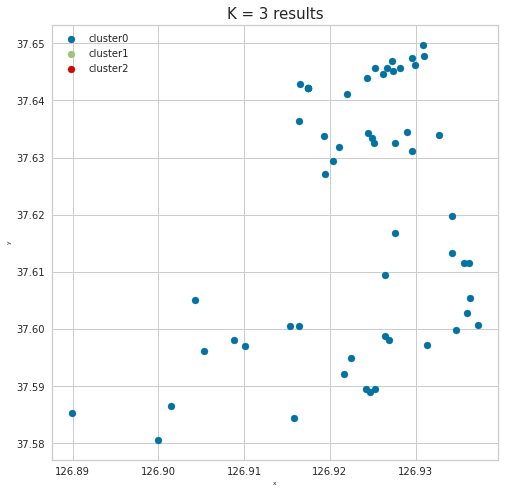

,자치구,field1,geometry,x,y,cluster
240,은평구,진관2로 90 진관동107 은평뉴타운 마고정,POINT (126.92756 37.63249),126.927561,37.632491,0.0
327,은평구,북한산로 2 진관동 은평뉴타운구파발,POINT (126.91653 37.64293),126.916534,37.642933,0.0
515,은평구,은평구 통일로 972진관동 235-28,POINT (126.92031 37.62942),126.920307,37.629424,0.0
538,은평구,은평구 통일로1045진광동 48,POINT (126.91644 37.63642),126.916444,37.636418,0.0
265,은평구,진관3로 15-35 진관동 은평뉴타운 구파발,POINT (126.91750 37.64211),126.917501,37.642115,0.0
264,은평구,진관3로 15-35 진관동 은평뉴타운 구파발,POINT (126.91750 37.64211),126.917501,37.642115,0.0
263,은평구,진관3로 15-35 진관동 은평뉴타운 구파발,POINT (126.91750 37.64211),126.917501,37.642115,0.0
262,은평구,진관3로 15-35 진관동 은평뉴타운 구파발,POINT (126.91750 37.64211),126.917501,37.642115,0.0
259,은평구,진관1로 77-8 진관동 은평뉴타운 폭포동,POINT (126.92958 37.63119),126.929585,37.631186,0.0
250,은평구,진관2로 77 진관동83 은평뉴타운우물골,POINT (126.92902 37.63448),126.929025,37.634478,0.0


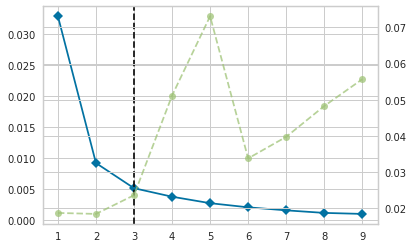

In [ ]:
eun_df , eun_center = make_cluster(geo_center, 3, "은평구", visualize = True, elbow = True)
eun_df[eun_df["자치구"] == "은평구"].sort_values(by="cluster")

In [ ]:
#cluster_dict = {"강남구" : [["강남1", "역삼동", "삼성동", "세곡동"] , ["강남2", "수서동", "개포동"]]}
cluster_dict["은평구"] = [["은평0구역", "진관동"], ["은평1구역", "응암동", "수색동", "신사동", "역촌동", "구산동" ], ["은평2구역", "녹번동", "불광동", "대조동"]]
#eunpyeong = {"은평구": [["은평0구역", "진관동"], ["은평1구역", "응암동", "수색동", "신사동", "역촌동", "구산동" ], ["은평2구역", "녹번동", "불광동", "대조동"]]}
cluster_dict

{'은평구': [['은평0구역', '진관동'],
  ['은평1구역', '응암동', '수색동', '신사동', '역촌동', '구산동'],
  ['은평2구역', '녹번동', '불광동', '대조동']]}

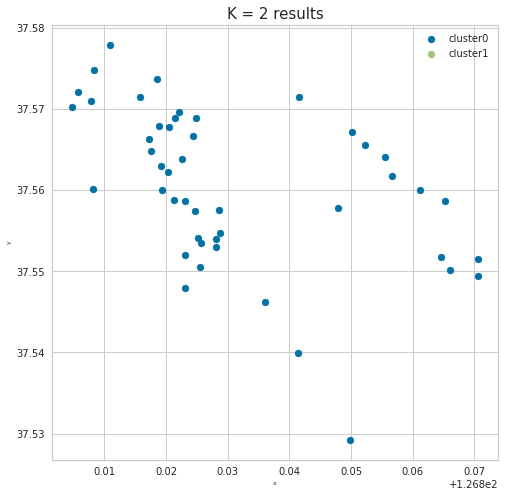

,자치구,field1,geometry,x,y,cluster
7,강서구,허준로 224 가양동 가양9단지아파트,POINT (126.86117 37.56001),126.861168,37.560008,0.0
626,강서구,공항대로543염창동 274-17,POINT (126.86598 37.55016),126.865981,37.550164,0.0
595,강서구,공항대로59가길 14등촌동 648-5,POINT (126.86459 37.55177),126.864587,37.551766,0.0
548,강서구,강서구 공항대로 583염창동 277-24,POINT (126.87058 37.54938),126.870576,37.549382,0.0
485,강서구,강서로 515,POINT (126.84160 37.57145),126.841605,37.571449,0.0
428,강서구,강서로5라길 26 화곡동 청년주택협동조합그랑,POINT (126.84980 37.52921),126.849797,37.529210,0.0
426,강서구,공항대로 359 등촌동 리본타워,POINT (126.84782 37.55784),126.847820,37.557844,0.0
397,강서구,양천로61길 50 가양동 이음채,POINT (126.86519 37.55864),126.865189,37.558637,0.0
629,강서구,강서로 145화곡동 401-1,POINT (126.84142 37.53990),126.841415,37.539901,0.0
355,강서구,양천로55길 55 가양동 강서한강자이,POINT (126.85011 37.56711),126.850105,37.567108,0.0


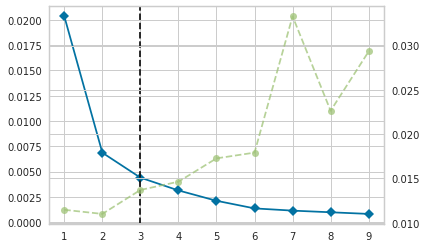

In [ ]:
gangseo_df , gangseo_center = make_cluster(geo_center, 2, "강서구", visualize = True, elbow = True)
gangseo_df[gangseo_df["자치구"] == "강서구"].sort_values(by="cluster")

In [ ]:
cluster_dict["gangseo"] = [["강서0구역", "가양동", "염창동", "등촌동", "화곡동", "내발산동"], ["강서1구역",  "공항동"]]
gangseo_center

array([[126.85527407,  37.55497685],
       [126.81979424,  37.56291626]])

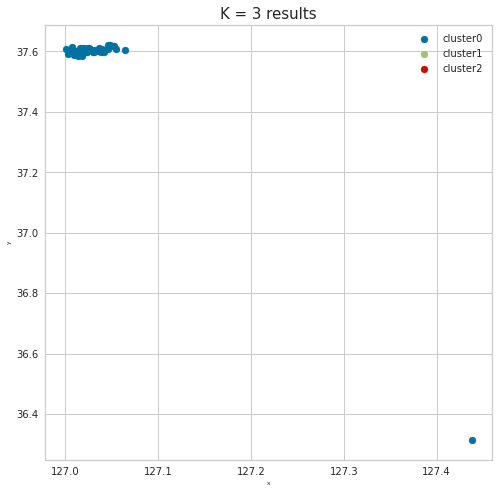

,자치구,field1,geometry,x,y,cluster
35,성북구,성북로4길 52 돈암동 한신한진아파트,POINT (127.00877 37.59602),127.008773,37.596020,0.0
267,성북구,길음로13길 22 길음동 길음7구역 두산위브아파트,POINT (127.01881 37.60926),127.018813,37.609263,0.0
272,성북구,길음로9길 50 길음동 길음뉴타운,POINT (127.01925 37.60389),127.019250,37.603892,0.0
326,성북구,정릉로 199 정릉동 정릉희망하우징,POINT (127.00689 37.60695),127.006891,37.606951,0.0
338,성북구,종암로 167 하월곡동 동일하이빌뉴시티,POINT (127.03099 37.60506),127.030991,37.605058,0.0
364,성북구,보문사길 40 보문동3가 이편한세상보문,POINT (127.01745 37.58367),127.017453,37.583666,0.0
399,성북구,동소문로34길 73 돈암동 길음역 금호어울림 센터힐,POINT (127.02235 37.60065),127.022354,37.600646,0.0
261,성북구,길음로 33 길음동 길음뉴타운,POINT (127.01890 37.60751),127.018903,37.607515,0.0
412,성북구,아리랑로19가길 20 정릉동 정릉 꿈에그린아파트,POINT (127.01095 37.60199),127.010950,37.601992,0.0
465,성북구,삼선동2가 77,POINT (127.00949 37.58772),127.009489,37.587723,0.0


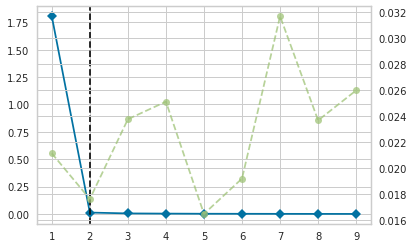

In [ ]:
seongbook_df , seongbook_center = make_cluster(geo_center, 3, "성북구", visualize = True, elbow = True)
seongbook_df[seongbook_df["자치구"] == "성북구"].sort_values(by="cluster")

In [ ]:
cluster_dict["seongbook"] = [["성북0구역", "돈암동", "길음동", "정릉동", "보문동", "성북동", "동소문동", "삼선동"], ["성북1구역", "종암동", "장위동", "석관동", "상월곡동", "하월곡동"]]
seongbook_center

array([[127.01749143,  37.60226171],
       [127.43768114,  36.31401587],
       [127.04551436,  37.60968664]])

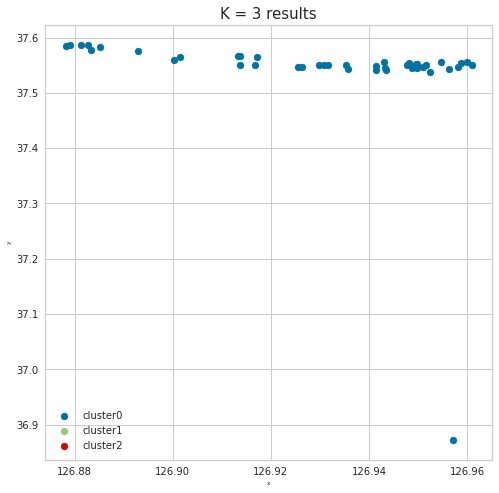

,자치구,field1,geometry,x,y,cluster
291,마포구,마포대로 173-15 공덕동 래미안 공덕5차,POINT (126.95157 37.55099),126.951575,37.550992,0.0
401,마포구,독막로20나길 21 상수동 래미안 밤섬리베뉴Ⅱ,POINT (126.92642 37.54735),126.926422,37.547345,0.0
400,마포구,독막로20나길 22 상수동 래미안 밤섬리베뉴Ⅰ,POINT (126.92551 37.54726),126.925508,37.547260,0.0
393,마포구,토정로31길 23 용강동 마포 리버웰,POINT (126.94135 37.54199),126.941351,37.541986,0.0
372,마포구,서강대길 40 대흥동 마포자이2차아파트,POINT (126.94152 37.54893),126.941521,37.548929,0.0
348,마포구,양화로 45 서교동 메세나폴리스,POINT (126.91368 37.55017),126.913678,37.550166,0.0
429,마포구,토정로18길 11 현석동 래미안웰스트림,POINT (126.93580 37.54278),126.935796,37.542775,0.0
659,마포구,신촌로34길 11아현동 327-10,POINT (126.95468 37.55669),126.954679,37.556690,0.0
460,마포구,마포대로 246아현동 아현 I-PARK,POINT (126.95999 37.55514),126.959990,37.555142,0.0
502,마포구,마포구 숭문길 98염리동 45,POINT (126.94964 37.55151),126.949639,37.551505,0.0


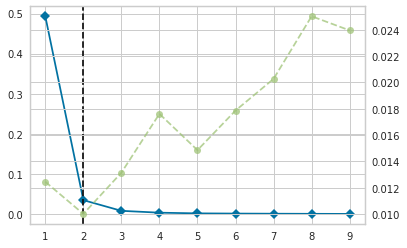

In [ ]:
mapo_df , mapo_center = make_cluster(geo_center, 3, "마포구", visualize = True, elbow = True)
mapo_df[mapo_df["자치구"] == "마포구"].sort_values(by="cluster")

In [ ]:
cluster_dict["마포구"]= [["마포0구역", "공덕동", "상수동", "서교동", "대흥동", "현석동", "아현동", "신공덕동", "창전동", "신수동", "도화동", "용강동", "염리동"], ["마포1구역", "성산동", "상암동", "망원동", "연남동"]]


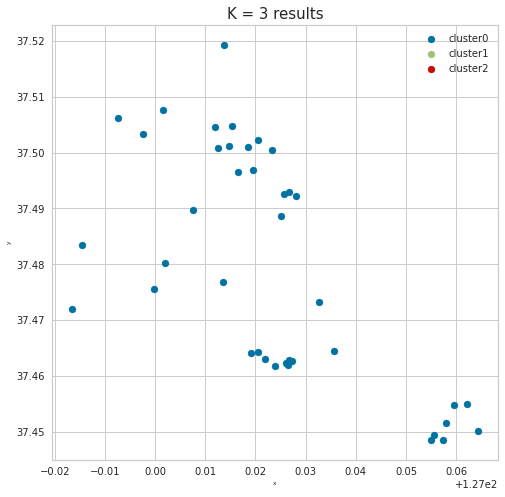

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
345,서초구,태봉로2길 60 우면동717 서초네이처힐3단지,POINT (127.02723 37.46269),127.027225,37.462691,0.0
392,서초구,매헌로16길 40 양재동 양재리본타워2단지,POINT (127.03575 37.46452),127.035746,37.464519,0.0
526,서초구,서초구 평창길 75잠원동 66,POINT (127.01350 37.47688),127.013501,37.476881,0.0
307,서초구,형촌길 60 우면동 네이처힐 가든,POINT (127.02057 37.46432),127.020571,37.464322,0.0
313,서초구,태봉로2길 65 우면동720 서초네이처힐4단지,POINT (127.02677 37.46295),127.026774,37.462952,0.0
314,서초구,태봉로2길 5 우면동 서초네이처힐5단지,POINT (127.02611 37.46231),127.026114,37.462308,0.0
315,서초구,태봉로2길 10 우면동735 서초네이처힐7단지,POINT (127.02389 37.46177),127.023893,37.461767,0.0
329,서초구,형촌길 15 우면동712 서초네이처힐2단지,POINT (127.02200 37.46301),127.022002,37.463007,0.0
341,서초구,형촌길 35 우면동707 서초네이처힐1단지,POINT (127.01911 37.46411),127.019106,37.464108,0.0
346,서초구,태봉로2길 30 우면동737 서초네이처힐6단지,POINT (127.02646 37.46201),127.026463,37.462007,0.0


In [ ]:
seocho_df , seocho_center = make_cluster(geo_center, 3, "서초구", visualize = True, elbow = False)
seocho_df[seocho_df["자치구"] == "서초구"].sort_values(by="cluster")

In [ ]:
cluster_dict["서초구"] = [["서초0구역", "우면동", "양재동", "잠원동"], ["서초1구역", "내곡동", "신원동"], ["서초2구역", "방배동", "서초동", "반포동"]]


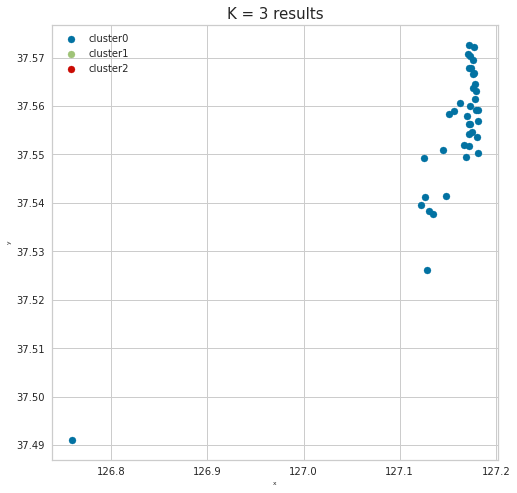

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
284,강동구,상일로 74 상일동490 고덕리엔파크3단지아파트,POINT (127.17562 37.55452),127.175619,37.554525,0.0
610,강동구,아리수로93가길 77강일동 215,POINT (127.17054 37.57074),127.170539,37.570743,0.0
605,강동구,고덕로399고덕동 210-1,POINT (127.16960 37.55788),127.169601,37.557878,0.0
604,강동구,고덕로 360상일동 519,POINT (127.17164 37.55414),127.171639,37.554141,0.0
593,강동구,강동구 아리수로93가길 110강일동 114번지,POINT (127.17170 37.57264),127.171696,37.572645,0.0
572,강동구,강동구 상암로79길 88상일동 187,POINT (127.16886 37.54951),127.168857,37.549506,0.0
571,강동구,강동구 고덕로80길 99상일동 131,POINT (127.16707 37.55198),127.167068,37.551983,0.0
564,강동구,상일로12길 95강일동 730-2,POINT (127.17239 37.55635),127.172387,37.556350,0.0
547,강동구,강동구 동남로82길 98고덕동 220,POINT (127.16244 37.56052),127.162439,37.560522,0.0
621,강동구,아리수로93나길 88강일동 66,POINT (127.17737 37.57215),127.177365,37.572150,0.0


In [ ]:
gangdong_df , gangdong_center = make_cluster(geo_center, 3, "강동구", visualize = True, elbow = False)
gangdong_df[gangdong_df["자치구"] == "강동구"].sort_values(by="cluster")

In [ ]:
cluster_dict["강동구"] = [["강동0구역", "상일동", "강일동", "고덕동"], ["강동1구역", "길동", "천호동", "성내동", "명일동", "암사동"]]


In [ ]:
gu_count[6:]

,field1,geometry,x,y
자치구,,,,
동대문구,38,38,38,38
강남구,34,34,34,34
성동구,32,32,32,32
노원구,30,30,30,30
서대문구,30,30,30,30
송파구,30,30,30,30
동작구,28,28,28,28
구로구,28,28,28,28
양천구,27,27,27,27


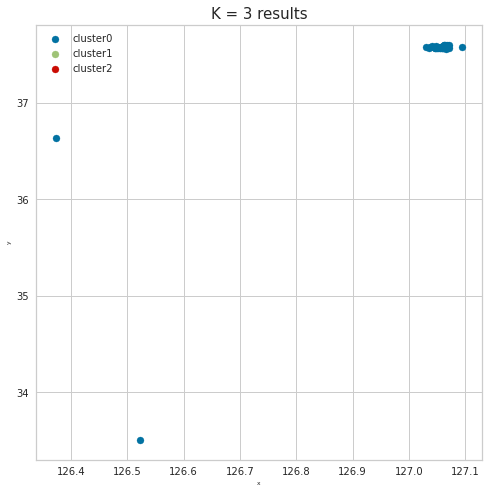

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
40,동대문구,제기로 129 청량리동 한신아파트,POINT (127.04779 37.58773),127.047795,37.587733,0.0
283,동대문구,서울시립대로 14 답십리동 청계한신휴플러스,POINT (127.04678 37.57267),127.046784,37.572671,0.0
302,동대문구,천호대로83길 71-7 장안동 일성트루엘아파트,POINT (127.06514 37.56547),127.065144,37.565472,0.0
320,동대문구,망우로20길 86 휘경동 브라운스톤 휘경,POINT (127.06657 37.59049),127.066575,37.590487,0.0
350,동대문구,사가정로 65 전농동 래미안크레시티아파트,POINT (127.05007 37.57524),127.050066,37.575238,0.0
398,동대문구,답십리로 130 답십리동 래미안위브아파트,POINT (127.05158 37.57150),127.051582,37.571503,0.0
407,동대문구,한빛로 73 용두동 용두롯데캐슬리치,POINT (127.03099 37.57892),127.030994,37.578917,0.0
470,동대문구,망우로18다길 31-5휘경동,POINT (127.06116 37.58605),127.061155,37.586053,0.0
491,동대문구,답십리로 23길 30전농동,POINT (127.05011 37.57716),127.050107,37.577156,0.0
492,동대문구,답십리로 141,POINT (127.05518 37.57387),127.055183,37.573873,0.0


In [ ]:
dongdae_df , dongdae_center = make_cluster(geo_center, 3, "동대문구", visualize = True, elbow = False)
dongdae_df[dongdae_df["자치구"] == "동대문구"].sort_values(by="cluster")

In [ ]:
cluster_dict["동대문구"] = [["동대문0구역", "청량리동", "답십리동", "장안동", "휘경동", "전농동", "면목동", " 이문동"], ["동대문1구역", "용두동"]]
dongdae_center

array([[127.05755194,  37.58130201],
       [126.52327734,  33.50448669],
       [126.37372501,  36.63355191]])

# 클러스터 정하기(pt.4 강남구부터)

In [ ]:
gu_count[7:]

,field1,geometry,x,y
자치구,,,,
강남구,34,34,34,34
성동구,32,32,32,32
노원구,30,30,30,30
서대문구,30,30,30,30
송파구,30,30,30,30
동작구,28,28,28,28
구로구,28,28,28,28
양천구,27,27,27,27
중랑구,20,20,20,20


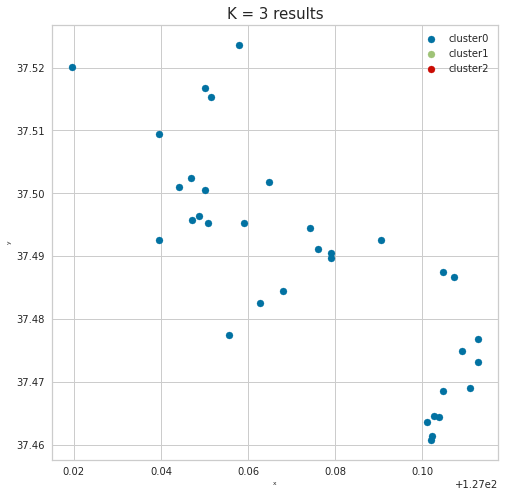

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
369,강남구,밤고개로21길 25 자곡동22 래미안포레,POINT (127.10913 37.47487),127.109125,37.474868,0.0
643,강남구,밤고개로21길 56 율현리엔파크율현동 524,POINT (127.11274 37.47316),127.112737,37.473160,0.0
10,강남구,광평로56길 11 수서동 수서6단지아파트,POINT (127.10475 37.48750),127.104754,37.487499,0.0
427,강남구,광평로60길 32 수서동 하니움,POINT (127.10720 37.48660),127.107204,37.486601,0.0
288,강남구,헌릉로590길 100 세곡동508 세곡리엔파크1단지,POINT (127.10102 37.46353),127.101022,37.463526,0.0
289,강남구,헌릉로590길 10 세곡동511 세곡리엔파크2단지,POINT (127.10268 37.46451),127.102682,37.464507,0.0
290,강남구,헌릉로590길 11 세곡동516 세곡리엔파크3단지,POINT (127.10383 37.46440),127.103825,37.464400,0.0
298,강남구,헌릉로590길 88 세곡동 세곡리엔파크4단지,POINT (127.10218 37.46133),127.102184,37.461330,0.0
419,강남구,밤고개로27길 20 율현동9 강남 한신휴플러스 8단지,POINT (127.11093 37.46906),127.110928,37.469056,0.0
312,강남구,헌릉로590길 63 세곡동525 강남데시앙파크,POINT (127.10189 37.46071),127.101893,37.460714,0.0


In [ ]:
gangnam_df , gangnam_center = make_cluster(geo_center, 3, "강남구", visualize = True, elbow = False)
gangnam_df[gangnam_df["자치구"] == "강남구"].sort_values(by="cluster")

In [ ]:
cluster_dict["강남구"] = [["강남0구역", "자곡동", "율현동", "수서동"], ["강남1구역", "삼성동", "역삼동", "논현동", "신사동", "청담동" ], ["강남2구역", "일원동", "개포동", "대치동"]]


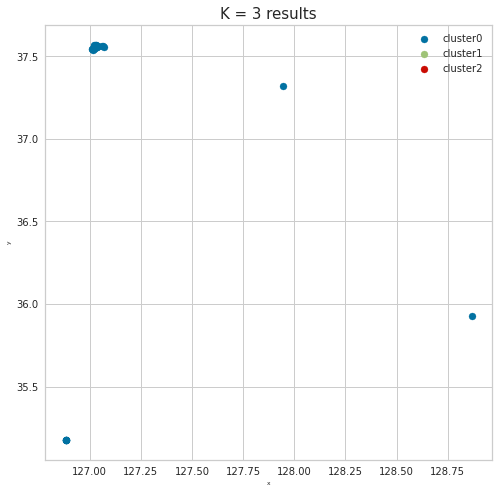

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
30,성동구,무학로 50 하왕십리동 벽산아파트,POINT (127.03187 37.56930),127.031872,37.569305,0.0
469,성동구,난계로 100하왕십리동 왕십리자이,POINT (127.02560 37.56010),127.025600,37.560101,0.0
436,성동구,금호로 173 금호동2가 신금호파크자이,POINT (127.01902 37.55461),127.019017,37.554605,0.0
414,성동구,무학로 33 하왕십리동 텐즈힐,POINT (127.02630 37.56971),127.026296,37.569712,0.0
377,성동구,마장로 137 상왕십리동 텐즈힐,POINT (127.02373 37.56998),127.023731,37.569982,0.0
349,성동구,매봉길 17 옥수동 래미안 옥수 리버젠,POINT (127.94291 37.32153),127.942910,37.321526,0.0
337,성동구,금호로3길 11 금호동4가 서울숲2차푸르지오,POINT (127.02389 37.54745),127.023891,37.547450,0.0
335,성동구,금호산8길 14 금호동3가 금호자이2차,POINT (127.02187 37.54966),127.021868,37.549655,0.0
296,성동구,고산자로 177 행당동 서울숲행당푸르지오아파트,POINT (127.03157 37.55484),127.031570,37.554843,0.0
490,성동구,고산자로2길 65행당동,POINT (127.03840 37.55427),127.038404,37.554267,0.0


In [ ]:
seongdong_df , seongdong_center = make_cluster(geo_center, 3, "성동구", visualize = True, elbow = False)
seongdong_df[seongdong_df["자치구"] == "성동구"].sort_values(by="cluster")

In [ ]:
cluster_dict["성동구"] = [["성동0구역", "하왕십리동", "상왕십리동", "행당동", "옥수동", "송정동", "마장동", "용답동" ], ["성동1구역", "금호동"]]


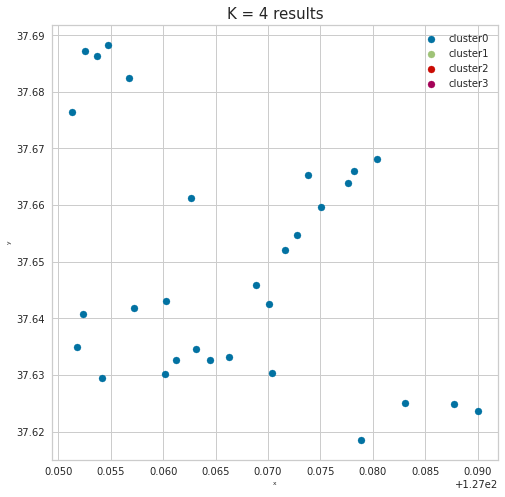

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
86,노원구,덕릉로118길 27 상계동 불암현대아파트,POINT (127.08042 37.66812),127.080424,37.668118,0.0
559,노원구,노원구 수락산로 12상계동 85-33,POINT (127.07378 37.66535),127.073785,37.665348,0.0
395,노원구,덕릉로 83길5 중계동 한화꿈에그린더퍼스트아파트,POINT (127.07502 37.65970),127.075023,37.659701,0.0
63,노원구,덕릉로77길 27 중계동 양지대림2차아파트,POINT (127.07276 37.65472),127.072761,37.654722,0.0
65,노원구,덕릉로73길 31 중계동 양지대림아파트,POINT (127.07158 37.65208),127.071579,37.652076,0.0
78,노원구,덕릉로94가길 41 상계동 상계불암대림아파트,POINT (127.07764 37.66397),127.077638,37.663972,0.0
81,노원구,덕릉로112길 13 상계동 동아불암아파트,POINT (127.07824 37.66603),127.078240,37.666028,0.0
607,노원구,노원로38길 10상계동 677,POINT (127.06261 37.66126),127.062609,37.661263,0.0
454,노원구,누원로 19 상계동,POINT (127.05250 37.68726),127.052501,37.687259,1.0
244,노원구,누원로 18 상계동1313 수락리버시티4단지,POINT (127.05371 37.68626),127.053708,37.686264,1.0


In [ ]:
nowon_df , nowon_center = make_cluster(geo_center, 4, "노원구", visualize = True, elbow = False)
nowon_df[nowon_df["자치구"] == "노원구"].sort_values(by="cluster")

In [ ]:
cluster_dict["노원구"] = [["노원0구역", "상계동", "중계동"], ["월계동", "공릉동"]]


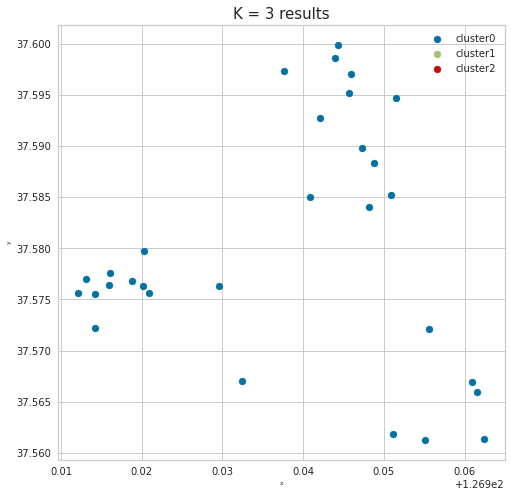

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
340,서대문구,수색로 100 북가좌동 DMC래미안e편한세상,POINT (126.91215 37.57558),126.912155,37.575584,0.0
600,서대문구,연희로12길 21-7연희동 136-21,POINT (126.93237 37.56707),126.932365,37.567068,0.0
28,서대문구,거북골로 154 북가좌동 북가좌삼호아파트,POINT (126.91306 37.57698),126.913062,37.576976,0.0
562,서대문구,거북골로 100남가좌동175,POINT (126.92014 37.57630),126.920143,37.576297,0.0
560,서대문구,서대문구 거북골로84남가좌동 224-1,POINT (126.91874 37.57675),126.918737,37.576754,0.0
58,서대문구,가재울로 45 남가좌동 남가좌동현대아파트,POINT (126.92084 37.57567),126.920843,37.575672,0.0
100,서대문구,증가로 191 남가좌동 남가좌삼성아파트,POINT (126.91607 37.57758),126.916067,37.577575,0.0
552,서대문구,서대문구 증가로 150남가좌동 388,POINT (126.92022 37.57976),126.920222,37.579764,0.0
202,서대문구,거북골로14길 32 북가좌동 DMC아이파크아파트,POINT (126.91415 37.57555),126.914152,37.575546,0.0
230,서대문구,거북골로 120 남가좌동 DMC센트레빌아파트,POINT (126.91595 37.57637),126.915955,37.576369,0.0


In [ ]:
seodae_df , seodae_center = make_cluster(geo_center, 3, "서대문구", visualize = True, elbow = False)
seodae_df[seongdong_df["자치구"] == "서대문구"].sort_values(by="cluster")

In [ ]:
cluster_dict["서대문구"] = [["서대문0구역", "북가좌동", "연희동", "남가좌동"], ["서대문1구역", "홍은동", "홍제동"], ["서대문2구역", "냉천동", "현저동", "북아현동", "중림동"]]

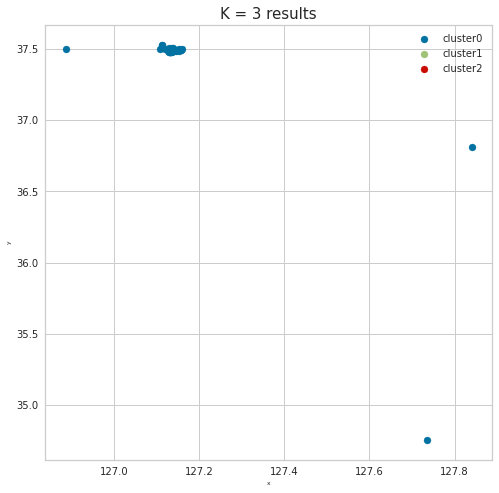

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
24,송파구,성내천로34길 8 마천동574 대성아파트,POINT (127.15324 37.49855),127.153236,37.498546,0.0
597,송파구,송파구 토성로6길 4풍납동 269-28,POINT (127.11271 37.53038),127.112709,37.530380,0.0
592,송파구,송파구 위례북로4길 12송파구 거여동 648,POINT (127.15172 37.48843),127.151724,37.488429,0.0
584,송파구,송파구 오금로 551송파구 거여동 234번지,POINT (127.15083 37.49415),127.150828,37.494150,0.0
573,송파구,송파구 올림픽로 43길 34풍납동 388-7,POINT (127.11347 37.52494),127.113468,37.524942,0.0
524,송파구,송파구 송파대로 345가락동 479,POINT (127.10892 37.49985),127.108920,37.499846,0.0
497,송파구,오금로53길 14거여동 12-12 거여리본타운,POINT (127.14230 37.49568),127.142295,37.495678,0.0
489,송파구,동남로 341오금동617 송파레미니스 2단지,POINT (127.13780 37.50543),127.137795,37.505426,0.0
479,송파구,성내천로 6오금동616 송파레미니스,POINT (127.13501 37.50760),127.135010,37.507600,0.0
475,송파구,위례순환로 477장지동 위례포레샤인23단지,POINT (127.13573 37.47573),127.135727,37.475728,0.0


In [ ]:
songpa_df , songpa_center = make_cluster(geo_center, 3, "송파구", visualize = True, elbow = False)
songpa_df[songpa_df["자치구"] == "송파구"].sort_values(by="cluster")

In [ ]:
cluster_dict["송파구"] = [["송파0구역", "마천동", "풍납동", "오금동", "거여동"], ["송파1구역", "장지동"]]

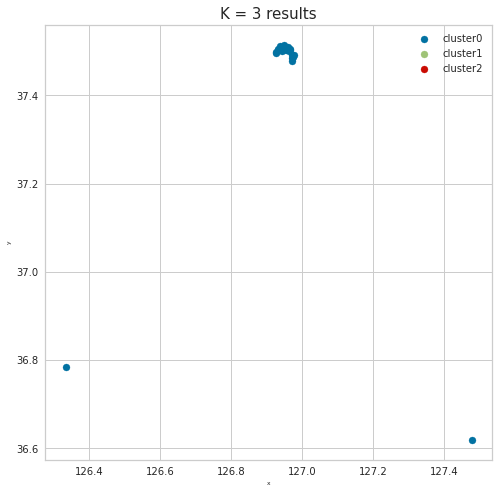

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
318,동작구,노량진로23가길 23 본동 래미안 트윈파크,POINT (126.94989 37.51464),126.949890,37.514644,0.0
596,동작구,양녕로 210-10 210-4상도동 211-438 467 435,POINT (126.94490 37.49957),126.944901,37.499566,0.0
563,동작구,사당로27길 215사당3동 177-1,POINT (126.97072 37.49146),126.970720,37.491464,0.0
549,동작구,동작구 만양로 6상도동 903,POINT (126.94848 37.50503),126.948478,37.505030,0.0
507,동작구,동작구 서달로 123흑석동 232-55,POINT (126.96040 37.50419),126.960404,37.504191,0.0
506,동작구,동작구 현충로 52흑석동 아크로리버하임,POINT (126.96105 37.51025),126.961052,37.510251,0.0
494,동작구,사당로 23길 112사당동16 래미안로이파크,POINT (126.97437 37.48786),126.974374,37.487856,0.0
449,동작구,장승배기로11가길 11 상도동 상도파크자이,POINT (126.93742 37.50596),126.937418,37.505963,0.0
444,동작구,상도로30길 40 상도동 상도2차두산위브트레지움아파트,POINT (126.94187 37.50371),126.941866,37.503708,0.0
433,동작구,상도로 207 상도동 상도효성해링턴플레이스,POINT (126.94237 37.50586),126.942367,37.505857,0.0


In [ ]:
dongjak_df , dongjak_center = make_cluster(geo_center, 3, "동작구", visualize = True, elbow = False)
dongjak_df[dongjak_df["자치구"] == "동작구"].sort_values(by="cluster")

In [ ]:
cluster_dict["동작구"] = [["동작0구역", "본동", "흑석동", "신대방동", "노량진동"], ["동작1구역", "상도동"]]


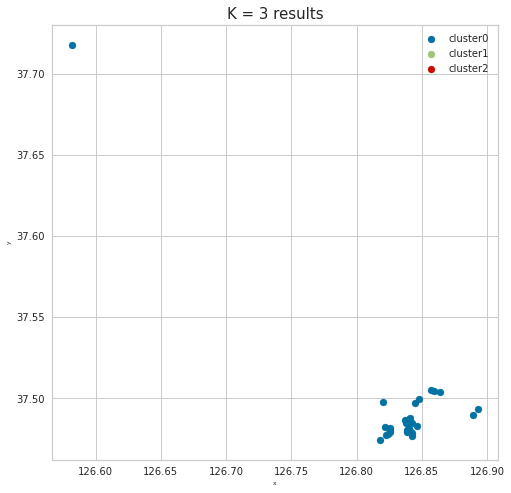

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
62,구로구,도림로 59 구로동 구로두산아파트,POINT (126.88937 37.48979),126.889366,37.489788,0.0
196,구로구,경인로47길 128 고척동 고척마젤란아파트,POINT (126.86426 37.50381),126.864257,37.503806,0.0
237,구로구,구로중앙로8길 41-23 구로동 경남아너스빌,POINT (126.89313 37.49318),126.893134,37.493184,0.0
276,구로구,고척로60길 30 고척동 벽산베스트블루밍아파트,POINT (126.85934 37.50433),126.859337,37.504328,0.0
501,구로구,구로구 고척로52나길25고척동156 고척리본타운,POINT (126.85736 37.50513),126.857362,37.505130,0.0
43,구로구,고척로 49 오류동 동부골든아파트,POINT (126.58188 37.71778),126.581884,37.717776,1.0
536,구로구,구로구 항동로 72항동 84일원,POINT (126.82602 37.48144),126.826016,37.481441,2.0
522,구로구,구로구 연동로 191-5항동 184,POINT (126.82283 37.47771),126.822830,37.477714,2.0
521,구로구,구로구 항동로 60항동 135-57,POINT (126.82582 37.47938),126.825824,37.479380,2.0
520,구로구,구로구 항동로68항동 136-1,POINT (126.82589 37.48032),126.825888,37.480321,2.0


In [ ]:
guro_df , guro_center = make_cluster(geo_center, 3, "구로구", visualize = True, elbow = False)
guro_df[guro_df["자치구"] == "구로구"].sort_values(by="cluster")

In [ ]:
cluster_dict["구로구"] = [["구로0구역", "도림동", "고척동"], ["구로1구역", "오류동"], ["구로2구역", "항동", "천왕동", "개봉동", "온수동"]]

# 클러스터 정하기(pt.5 양천구부터)

In [ ]:
gu_count[14:]

,field1,geometry,x,y
자치구,,,,
양천구,27,27,27,27
중랑구,20,20,20,20
영등포구,18,18,18,18
관악구,16,16,16,16
강북구,15,15,15,15
중구,10,10,10,10
종로구,8,8,8,8
도봉구,6,6,6,6
광진구,6,6,6,6


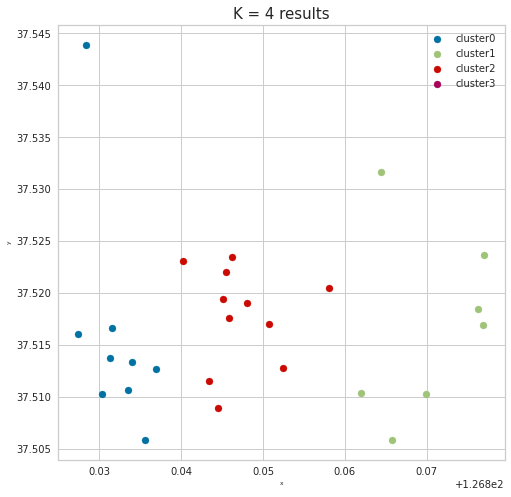

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
197,양천구,월정로 303 신월동 수명산롯데캐슬,POINT (126.82840 37.54392),126.828400,37.543920,0.0
281,양천구,오목로5길 19 신월동 양천롯데캐슬,POINT (126.84024 37.52309),126.840244,37.523091,1.0
384,양천구,신정로13가길 6 신정동 신정도시마을주택,POINT (126.84345 37.51148),126.843454,37.511477,1.0
378,양천구,중앙로29길 61 신월동 신정뉴타운롯데캐슬,POINT (126.84811 37.51899),126.848111,37.518986,1.0
328,양천구,신월로20길 7 신월동 신정뉴타운두산위브아파트,POINT (126.84512 37.51939),126.845118,37.519392,1.0
619,양천구,중앙로43길 14신정동 1175-28,POINT (126.85077 37.51697),126.850767,37.516974,1.0
166,양천구,오목로 76-2 신월동 장수마을2단지동원데쟈뷰아파트,POINT (126.84548 37.52203),126.845480,37.522034,1.0
437,양천구,중앙로36길 15 신정동 목동힐스테이트,POINT (126.85806 37.52048),126.858056,37.520481,1.0
101,양천구,신정로14길 1 신정동 학마을아파트,POINT (126.84448 37.50892),126.844479,37.508924,1.0
89,양천구,신정로 275 신정동 신트리2단지아파트,POINT (126.85249 37.51275),126.852489,37.512749,1.0


In [ ]:
yangcheon_df , yangcheon_center = make_cluster(geo_center, 4, "양천구", visualize = True, elbow = False)
yangcheon_df[yangcheon_df["자치구"] == "양천구"].sort_values(by="cluster")

In [ ]:
cluster_dict["양천구"]= [["양천0구역", "신월동"], ["양천1구역", "신정동"], ["양천2구역", "목동"]]

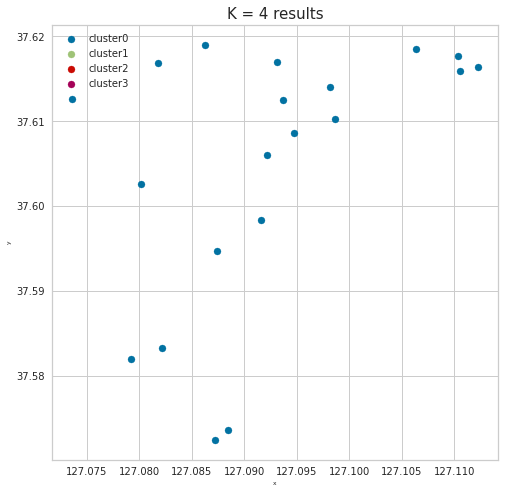

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
374,중랑구,망우로 353 상봉동 상봉 프레미어스 엠코,POINT (127.09162 37.59833),127.091624,37.598333,0.0
214,중랑구,중랑천로 316 묵동 묵동월드메르디앙아파트,POINT (127.07360 37.61268),127.073598,37.612680,0.0
165,중랑구,동일로136길 15 중화동 청광플러스원,POINT (127.08019 37.60257),127.080193,37.602573,0.0
656,중랑구,면목로92가길 15-11상봉동 104-33,POINT (127.08740 37.59465),127.087402,37.594647,0.0
360,중랑구,신내역로 165 신내동817 신내우디안2단지,POINT (127.11052 37.61598),127.110522,37.615977,1.0
389,중랑구,신내역로1길 85 신내동816 신내우디안1단지,POINT (127.10637 37.61847),127.106373,37.618469,1.0
474,중랑구,신내역로1길 142신내동 우디안3단지,POINT (127.11035 37.61766),127.110353,37.617662,1.0
499,중랑구,중랑구 신내역로 160신내동 신내3,POINT (127.11226 37.61645),127.112259,37.616447,1.0
606,중랑구,동일로91길 23면목동 171-7,POINT (127.07919 37.58198),127.079195,37.581978,2.0
410,중랑구,용마산로 210 면목동 용마산 하늘채,POINT (127.08722 37.57241),127.087223,37.572406,2.0


In [ ]:
joonglang_df , joonglang_center = make_cluster(geo_center, 4, "중랑구", visualize = True, elbow = False)
joonglang_df[joonglang_df["자치구"] == "중랑구"].sort_values(by="cluster")

In [ ]:
cluster_dict["중랑구"] = [["중랑0구역", "상봉동", "중화동", "묵동"], ["중랑1구역", "신내동"], ["중랑2구역", "면목동"]]

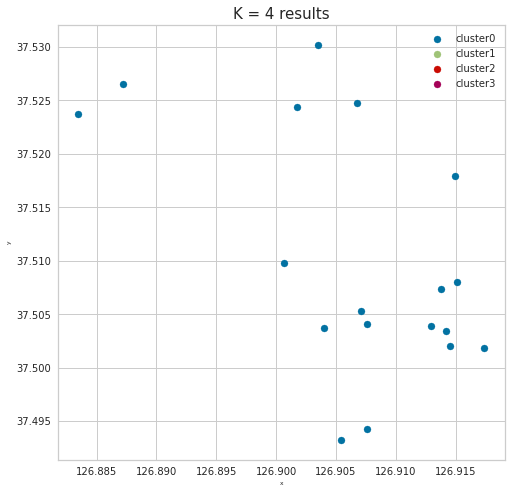

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
70,영등포구,신길로42가길 34 신길동4935 신기목련아파트,POINT (126.91509 37.50806),126.915090,37.508060,0.0
591,영등포구,영등포구 신길로28길9신길동240-16,POINT (126.91297 37.50394),126.912973,37.503939,0.0
561,영등포구,여의대방로35가길 19신길동 1583-1,POINT (126.91740 37.50188),126.917397,37.501877,0.0
614,영등포구,영등포구 신길로28길 25신길동3163,POINT (126.91423 37.50340),126.914232,37.503399,0.0
466,영등포구,신풍로 77신길동 래미안에스티움,POINT (126.91455 37.50205),126.914554,37.502054,0.0
111,영등포구,신길로42길 25 신길동 삼성아파트,POINT (126.91374 37.50732),126.913737,37.507322,0.0
79,영등포구,영등포로 17 양평동2가45 상록수아파트,POINT (126.88349 37.52372),126.883486,37.523724,1.0
198,영등포구,선유서로34길 6 양평동3가 양평동1차 태승훼미리아파트,POINT (126.88718 37.52655),126.887184,37.526550,1.0
145,영등포구,영신로 183 당산동3가 당산 SH VILLE,POINT (126.90173 37.52440),126.901726,37.524401,2.0
471,영등포구,국회대로 54길10영등포동7가 아크로타워 스퀘어,POINT (126.90678 37.52471),126.906776,37.524711,2.0


In [ ]:
yeongdeung_df , yeongdeung_center = make_cluster(geo_center, 4, "영등포구", visualize = True, elbow = False)
yeongdeung_df[yeongdeung_df["자치구"] == "영등포구"].sort_values(by="cluster")

In [ ]:
cluster_dict["영등포구"] = [["영등포0구역", "신길동", "도림동", "대림동"], ["영등포1구역", "양평동"], ["영등포2구역", "당산동"]]

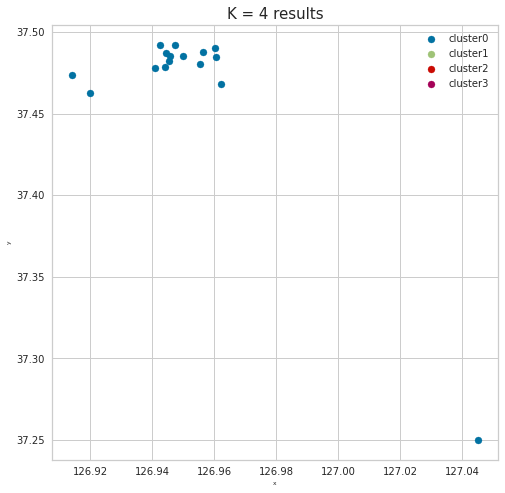

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
57,관악구,낙성대로15길 66 봉천동1725 인헌아파트,POINT (126.96230 37.46798),126.962297,37.467981,0.0
77,관악구,관악로37길 20 봉천동 봉천동아아파트,POINT (126.95640 37.48771),126.956400,37.487714,0.0
87,관악구,관악로30길 40 봉천동 봉천우성아파트,POINT (126.96068 37.48457),126.960684,37.484570,0.0
140,관악구,청림5길 28 봉천동 관악푸르지오2단지아파트,POINT (126.96015 37.49002),126.960146,37.490024,0.0
652,관악구,남부순환로 1845봉천동 1666-51,POINT (126.95529 37.48066),126.955288,37.480661,0.0
12,관악구,신원로 26 신림동 신림동부아파트,POINT (127.04513 37.25003),127.045129,37.250034,1.0
71,관악구,미성5길 40 신림동1712 초원아파트,POINT (126.91407 37.47382),126.914065,37.473816,2.0
163,관악구,난곡로 80 신림동 신림SH Ville아파트,POINT (126.91988 37.46246),126.919880,37.462461,2.0
67,관악구,양녕로6나길 18 봉천동1705 신봉아파트,POINT (126.94982 37.48503),126.949816,37.485025,3.0
106,관악구,양녕로 31 봉천동 두산아파트,POINT (126.94578 37.48516),126.945782,37.485155,3.0


In [ ]:
gwanak_df , gwanak_center = make_cluster(geo_center, 4, "관악구", visualize = True, elbow = False)
gwanak_df[gwanak_df["자치구"] == "관악구"].sort_values(by="cluster")

In [ ]:
cluster_dict["관악구"] = [["관악0구역", "봉천동"], ["관악1구역", "신림동"]]


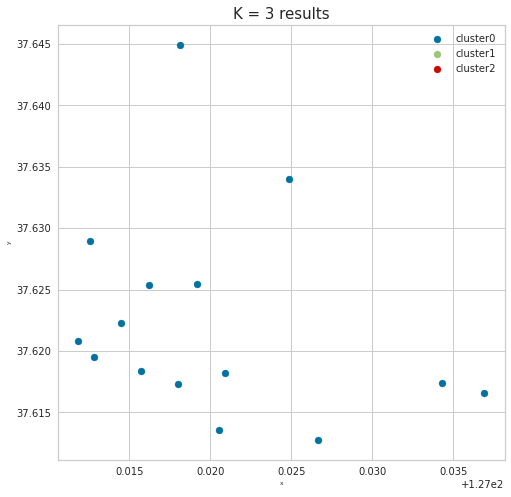

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
122,강북구,솔샘로 174 미아동 SK북한산시티아파트,POINT (127.01285 37.61955),127.012851,37.619550,0.0
130,강북구,솔샘로 159 미아동 벽산라이브파크,POINT (127.01187 37.62083),127.011873,37.620835,0.0
141,강북구,삼양로19길 113 미아동 삼각산아이원아파트,POINT (127.01801 37.61732),127.018011,37.617320,0.0
159,강북구,삼양로 246-14 미아동 미아 에스에이치빌 아파트,POINT (127.01920 37.62542),127.019199,37.625425,0.0
257,강북구,삼양로19길 25 미아동 삼성래미안트리베라1차아파트,POINT (127.02056 37.61359),127.020564,37.613594,0.0
258,강북구,삼양로27길 19 미아동 삼성래미안트리베라아파트,POINT (127.02094 37.61818),127.020938,37.618175,0.0
317,강북구,삼양로27길 95 미아동 두산위브트레지움아파트,POINT (127.01575 37.61835),127.015754,37.618351,0.0
408,강북구,인수봉로 101 수유동 프레비스타,POINT (127.01261 37.62897),127.012614,37.628970,0.0
616,강북구,솔매로 36미아동 791-1614,POINT (127.01622 37.62539),127.016218,37.625395,0.0
646,강북구,인수봉로6가길 12삼양동 791-1960 외,POINT (127.01448 37.62230),127.014481,37.622296,0.0


In [ ]:
gangbook_df , gangbook_center = make_cluster(geo_center, 3, "강북구", visualize = True, elbow = False)
gangbook_df[gangbook_df["자치구"] == "강북구"].sort_values(by="cluster")

In [ ]:
cluster_dict["강북구"] = [["강북0구역",  "미아동", "수유동", "삼양동"]]


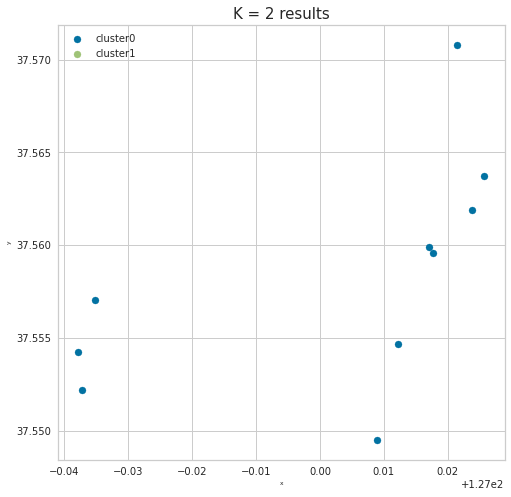

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
108,중구,중림로4길 41 중림동 삼성사이버빌리지,POINT (126.96485 37.55706),126.964846,37.557056,0.0
409,중구,만리재로27길 69 만리동2가,POINT (126.96224 37.55425),126.962238,37.554253,0.0
478,중구,만리재로 175,POINT (126.96273 37.55220),126.962729,37.552197,0.0
76,중구,동호로10길 30 신당동 약수하이츠,POINT (127.01228 37.55469),127.012284,37.554690,1.0
84,중구,청구로1길 23 신당동 삼성아파트,POINT (127.01768 37.55959),127.017683,37.559591,1.0
90,중구,왕십리로39길 30 신당동 한진그랑빌아파트,POINT (127.02571 37.56373),127.025713,37.563733,1.0
94,중구,다산로 32 신당동 남산타운,POINT (127.00887 37.54950),127.008873,37.549495,1.0
175,중구,청계천로 400 황학동 롯데캐슬베네치아,POINT (127.02146 37.57081),127.021463,37.570810,1.0
316,중구,퇴계로90길 74 신당동 래미안신당하이베르아파트,POINT (127.02381 37.56189),127.023810,37.561888,1.0
319,중구,청구로 64 신당동 청구 e편한세상,POINT (127.01714 37.55991),127.017140,37.559906,1.0


In [ ]:
joong_df , joong_center = make_cluster(geo_center, 2, "중구", visualize = True, elbow = False)
joong_df[joong_df["자치구"] == "중구"].sort_values(by="cluster")

In [ ]:
cluster_dict["중구"] = [["중0구역", "중림동", "만리동"], ["중1구역", "신당동", "황학동"]]


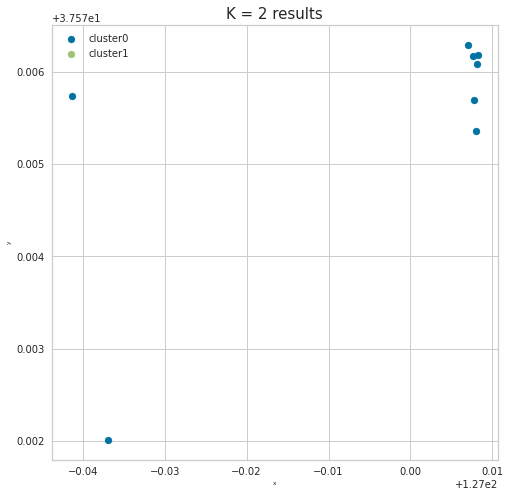

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
83,종로구,통일로 246-11 무악동 무악현대아파트,POINT (126.95867 37.57573),126.958669,37.575734,0.0
467,종로구,송월길 130행촌동 경희궁자이 1단지,POINT (126.96306 37.57201),126.963058,37.572010,0.0
512,종로구,종로구 충신4길 28-3 충신동 1-198,POINT (127.00799 37.57536),127.007992,37.575356,1.0
513,종로구,종로구 충신4길 31-24 충신동 1-136,POINT (127.00820 37.57618),127.008201,37.576179,1.0
529,종로구,종로구 충신4길 18충신동 1-232,POINT (127.00780 37.57569),127.007801,37.575687,1.0
531,종로구,종로구 충신길 80-4충신동 1-66,POINT (127.00703 37.57629),127.007030,37.576291,1.0
532,종로구,종로구 충신4길 31-22충신동 1-139,POINT (127.00817 37.57608),127.008171,37.576079,1.0
537,종로구,종로구 충신4길 17-15충신동 1-239,POINT (127.00768 37.57616),127.007678,37.576164,1.0


In [ ]:
jongno_df , jongno_center = make_cluster(geo_center, 2, "종로구", visualize = True, elbow = False)
jongno_df[jongno_df["자치구"] == "종로구"].sort_values(by="cluster")

In [ ]:
cluster_dict["종로구"] = [["종로0구역", "무악동", "행촌동"], ["종로1구역", "충신동"]]

# 클러스터 정하기(pt.6 도봉구부터)

In [ ]:
gu_count[20:]

,field1,geometry,x,y
자치구,,,,
종로구,8,8,8,8
도봉구,6,6,6,6
광진구,6,6,6,6
금천구,6,6,6,6
용산구,6,6,6,6


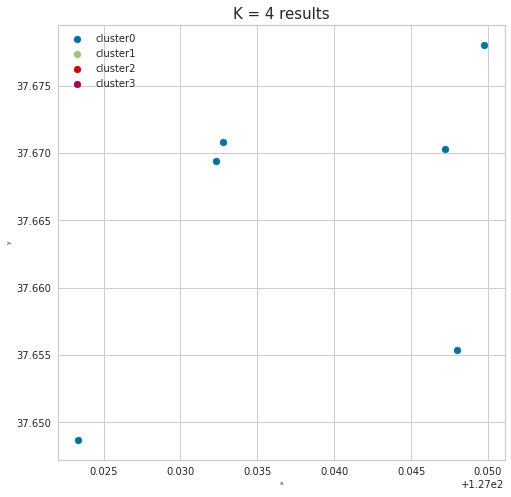

elbow 없이 visualizing을 어떻게 합니까..


,자치구,field1,geometry,x,y,cluster
33,도봉구,마들로 684-20 도봉동 서원아파트,POINT (127.04720 37.67026),127.047198,37.670260,0.0
74,도봉구,마들로 770 도봉동643 서광아파트,POINT (127.04976 37.67804),127.049764,37.678043,0.0
357,도봉구,우이천로 367 쌍문동 북한산코오롱하늘채아파트,POINT (127.02337 37.64868),127.023368,37.648682,1.0
362,도봉구,시루봉로15라길 63 방학동 393-16,POINT (127.03275 37.67082),127.032748,37.670817,2.0
363,도봉구,시루봉로17길 48-2 방학동 394-11,POINT (127.03229 37.66943),127.032294,37.669429,2.0
598,도봉구,도봉구 마들로13길 84창동 1-8,POINT (127.04800 37.65538),127.048003,37.655376,3.0


In [ ]:
dobong_df , dobong_center = make_cluster(geo_center, 4, "도봉구", visualize = True, elbow = False)
dobong_df[dobong_df["자치구"] == "도봉구"].sort_values(by="cluster")

In [ ]:
cluster_dict["도봉구"] = [["도봉0구역", "도봉동"], ["도봉1구역", "쌍문동", "방학동"], ["도봉2구역", "창동"]]

In [ ]:
geo_center[geo_center["자치구"] == "광진구"]

,자치구,field1,geometry,x,y,cluster
238,광진구,영화사로16길 43 구의동 구의동 아차산 한라아파트,POINT (127.09699 37.55414),127.096987,37.554137,0.0
477,광진구,아차산로 345자양동 래미안프리미어팰리스아파트,POINT (127.12762 37.58654),127.127620,37.586544,0.0
508,광진구,광진구 아차산로 431구의동 667,POINT (127.09019 37.53865),127.090190,37.538654,0.0
578,광진구,광진구 구의강변로 53구의동 587-64,POINT (127.09190 37.53573),127.091900,37.535733,0.0
660,광진구,광나루로 20길 36-3화양동 94-13,POINT (127.07384 37.54534),127.073837,37.545338,0.0
665,광진구,광나루로 20길 34화양동 111-89,POINT (127.07395 37.54560),127.073950,37.545603,0.0


In [ ]:
cluster_dict["광진구"] = [["광진0구역", "구의동"], ["광진1구역", "화양동"]]

In [ ]:
geo_center[geo_center["자치구"] == "금천구"]

,자치구,field1,geometry,x,y,cluster
32,금천구,금하로3길 26 시흥동1009 시흥목련아파트,POINT (126.89805 37.45475),126.898052,37.454749,0.0
52,금천구,금하로 793 시흥동 벽산2단지아파트,POINT (126.91742 37.45015),126.917416,37.450149,0.0
129,금천구,금하로 796 시흥동 벽산6단지아파트,POINT (126.91563 37.44988),126.915626,37.449877,0.0
173,금천구,금하로23길 52 시흥동 백운한비치Ⅱ,POINT (126.90934 37.45358),126.909341,37.453575,0.0
423,금천구,시흥대로24길 50 시흥동,POINT (126.90717 37.44128),126.907166,37.441275,0.0
453,금천구,벚꽃로 40 독산동 금천롯데캐슬골드파크1차아파트,POINT (126.83622 36.68377),126.836224,36.683773,0.0


In [ ]:
cluster_dict['금천구'] = [["금천0구역", "시흥동", "독산동"]]


In [ ]:
geo_center[geo_center["자치구"] == "용산구"]

,자치구,field1,geometry,x,y,cluster
99,용산구,효창원로13길 7 산천동 리버힐삼성아파트,POINT (126.95244 37.53539),126.952440,37.535388,0.0
118,용산구,새창로8길 7 도원동 도원동삼성래미안아파트,POINT (126.95252 37.53829),126.952520,37.538290,0.0
287,용산구,원효로 216 신계동 용산e편한세상,POINT (128.75949 35.81794),128.759489,35.817941,0.0
530,용산구,용산구 백범로 313효창동 13-2,POINT (126.96389 37.54016),126.963893,37.540161,0.0
589,용산구,서빙고로 17한강로3가 63-70,POINT (126.96788 37.52527),126.967883,37.525271,0.0
633,용산구,백범로99길 40한강로 2가 2-350,POINT (126.97180 37.53621),126.971800,37.536206,0.0


In [ ]:
cluster_dict["용산구"] = [["산천동", "신계동", "효창동", "한강로동"]]

# 클러스터 재정리, df 만들기 (pt. 1)


In [ ]:
cluster_dict.keys()

dict_keys(['은평구', 'gangseo', 'seongbook', '마포구', '서초구', '강동구', '동대문구', '강남구', '성동구', '노원구', '서대문구', '송파구', '동작구', '구로구', '양천구', '중랑구', '영등포구', '관악구', '강북구', '중구', '종로구', '도봉구', '광진구', '금천구', '용산구'])

In [ ]:
cluster_dict["강서구"] = cluster_dict.pop("gangseo")
cluster_dict["성북구"] = cluster_dict.pop("seongbook")
cluster_dict.keys()

dict_keys(['은평구', '마포구', '서초구', '강동구', '동대문구', '강남구', '성동구', '노원구', '서대문구', '송파구', '동작구', '구로구', '양천구', '중랑구', '영등포구', '관악구', '강북구', '중구', '종로구', '도봉구', '광진구', '금천구', '용산구', '강서구', '성북구'])

In [ ]:
cluster_dict.values()

dict_values([[['은평0구역', '진관동'], ['은평1구역', '응암동', '수색동', '신사동', '역촌동', '구산동'], ['은평2구역', '녹번동', '불광동', '대조동']], [['마포0구역', '공덕동', '상수동', '서교동', '대흥동', '현석동', '아현동', '신공덕동', '창전동', '신수동', '도화동', '용강동', '염리동'], ['마포1구역', '성산동', '상암동', '망원동', '연남동']], [['서초0구역', '우면동', '양재동', '잠원동'], ['서초1구역', '내곡동', '신원동'], ['서초2구역', '방배동', '서초동', '반포동']], [['강동0구역', '상일동', '강일동', '고덕동'], ['강동1구역', '길동', '천호동', '성내동', '명일동', '암사동']], [['동대문0구역', '청량리동', '답십리동', '장안동', '휘경동', '전농동', '면목동', ' 이문동'], ['동대문1구역', '용두동']], [['강남0구역', '자곡동', '율현동', '수서동'], ['강남1구역', '삼성동', '역삼동', '논현동', '신사동', '청담동'], ['강남2구역', '일원동', '개포동', '대치동']], [['성동0구역', '하왕십리동', '상왕십리동', '행당동', '옥수동', '송정동', '마장동', '용답동'], ['성동1구역', '금호동']], [['노원0구역', '상계동', '중계동'], ['월계동', '공릉동']], [['서대문0구역', '북가좌동', '연희동', '남가좌동'], ['서대문1구역', '홍은동', '홍제동'], ['서대문2구역', '냉천동', '현저동', '북아현동', '중림동']], [['송파0구역', '마천동', '풍납동', '오금동', '거여동'], ['송파1구역', '장지동']], [['동작0구역', '본동', '흑석동', '신대방동', '노량진동'], ['동작1구역', '상도동']], [['구로0구역', '도림동', '고척동'], ['구로1구역',

In [ ]:
gu_list = list(cluster_dict.keys())
region = np.array([len(cluster_dict[gu]) for gu in cluster_dict.keys()]).reshape(-1, 1)
region_df = pd.DataFrame(region)
region_df.index = gu_list
region_df.columns = ["#구역"]
region_df.shape

(25, 1)

In [ ]:
key_df = pd.DataFrame([cluster_dict[key] for key in cluster_dict.keys()])
key_df.index = gu_list
key_df.columns = ["0구역", "1구역", "2구역"]
cluster_df = pd.concat([region_df, key_df], axis = 1)
cluster_df.head()

,#구역,0구역,1구역,2구역
은평구,3,"[은평0구역, 진관동]","[은평1구역, 응암동, 수색동, 신사동, 역촌동, 구산동]","[은평2구역, 녹번동, 불광동, 대조동]"
마포구,2,"[마포0구역, 공덕동, 상수동, 서교동, 대흥동, 현석동, 아현동, 신공덕동, 창전...","[마포1구역, 성산동, 상암동, 망원동, 연남동]",None
서초구,3,"[서초0구역, 우면동, 양재동, 잠원동]","[서초1구역, 내곡동, 신원동]","[서초2구역, 방배동, 서초동, 반포동]"
강동구,2,"[강동0구역, 상일동, 강일동, 고덕동]","[강동1구역, 길동, 천호동, 성내동, 명일동, 암사동]",None
동대문구,2,"[동대문0구역, 청량리동, 답십리동, 장안동, 휘경동, 전농동, 면목동, 이문동]","[동대문1구역, 용두동]",None


In [ ]:
def lose_gu(x):
  if x is None:
    return x
  else:
    return x[1:]

In [ ]:
cluster_df["0구역"] = cluster_df["0구역"].apply(lambda x : lose_gu(x))
cluster_df["1구역"] = cluster_df["1구역"].apply(lambda x: lose_gu(x)) 
cluster_df["2구역"] = cluster_df["2구역"].apply(lambda x: lose_gu(x))

In [ ]:
cluster_df

,#구역,0구역,1구역,2구역
은평구,3,[진관동],"[응암동, 수색동, 신사동, 역촌동, 구산동]","[녹번동, 불광동, 대조동]"
마포구,2,"[공덕동, 상수동, 서교동, 대흥동, 현석동, 아현동, 신공덕동, 창전동, 신수동,...","[성산동, 상암동, 망원동, 연남동]",None
서초구,3,"[우면동, 양재동, 잠원동]","[내곡동, 신원동]","[방배동, 서초동, 반포동]"
강동구,2,"[상일동, 강일동, 고덕동]","[길동, 천호동, 성내동, 명일동, 암사동]",None
동대문구,2,"[청량리동, 답십리동, 장안동, 휘경동, 전농동, 면목동, 이문동]",[용두동],None
강남구,3,"[자곡동, 율현동, 수서동]","[삼성동, 역삼동, 논현동, 신사동, 청담동]","[일원동, 개포동, 대치동]"
성동구,2,"[하왕십리동, 상왕십리동, 행당동, 옥수동, 송정동, 마장동, 용답동]",[금호동],None
노원구,2,"[상계동, 중계동]",[공릉동],None
서대문구,3,"[북가좌동, 연희동, 남가좌동]","[홍은동, 홍제동]","[냉천동, 현저동, 북아현동, 중림동]"
송파구,2,"[마천동, 풍납동, 오금동, 거여동]",[장지동],None


In [ ]:
#cluster_dict = {"강남구" : [["클러스터1", "역삼동", "삼성동", "세곡동"] , ["클러스터2", "수서동", "개포동"]], "강동구": ...}
#서울시 내 각 구별 인구 비율
def whole_compute_ratio(df):
  total = df.groupby("시군구명")["계"].sum().sum()
  ratio = df.groupby("시군구명")["계"].sum()/total
  return ratio

whole_compute_ratio(people)

#df 에 데이터 넘겨주고 dc에 앞에서 정한 클러스터 넘겨줌. 특정 구를 알려주면 그 구 내 클러스터들이 각각 어느정도 비율의 사람들이 있는지 알 수 있음(장애인 분포 결정을 위한 함수)

gu = ""
dc = {}
df = pd.DataFrame()
def ingu_compute_ratio(df, dc, gu):
  cluster_dc = {}
  d_list_cluster = dc[gu]
  for i in range(len(d_list_cluster)):
    in_cluster = d_list_cluster[i]
    number = 0
    for n, d in enumerate(in_cluster):
      if n == 0 :
        cluster_name = in_cluster[n]

      else:

      
        try: 
          number+=df[df["읍면동명"] ==d]["계"].values
        except:
          print(d, "같은 동은 없습니다!")
          
          pass
    cluster_dc[cluster_name] = int(number)
  
  return cluster_dc
    




In [ ]:
def ingu_whole_ratio(dct):
  empty_list = []
  length = len(list(dct.keys()))
  whole_number = sum(list(dct.values()))
  for i in range(length):
    empty_list.append(list(dct.values())[i]/whole_number)
  return empty_list

In [ ]:
double_dict = {}
wrong_list = []
for gu in gu_list:
  try:
    dic = ingu_compute_ratio(people, cluster_dict, str(gu))
    empty = ingu_whole_ratio(dic)
    double_dict[gu] = empty
    #print(gu, empty)
  except:
    wrong_list.append(gu)
    print(gu, "는 문제가 됩니다")



신사동 같은 동은 없습니다!
 이문동 같은 동은 없습니다!
신사동 같은 동은 없습니다!
성동구 는 문제가 됩니다
양천구 는 문제가 됩니다
영등포구 는 문제가 됩니다
삼양동 같은 동은 없습니다!
만리동 같은 동은 없습니다!
한강로동 같은 동은 없습니다!
보문동 같은 동은 없습니다!
동소문동 같은 동은 없습니다!
삼선동 같은 동은 없습니다!


In [ ]:
cluster_df = cluster_df.drop(wrong_list, axis = 0)



In [ ]:
double_list = list(double_dict.values())
#double_array = np.array(double_dict.values())
#pd.DataFrame(double_array
ratio_df = pd.DataFrame(double_list)
ratio_df.columns = ["0구역 비율", "1구역 비율", "2구역 비율"]
ratio_df.index = cluster_df.index
cluster_df = pd.concat([cluster_df, ratio_df], axis=1)
cluster_df.head(5)

,#구역,0구역,1구역,2구역,0구역 비율,1구역 비율,2구역 비율
은평구,3,[진관동],"[응암동, 수색동, 신사동, 역촌동, 구산동]","[녹번동, 불광동, 대조동]",0.153865,0.487982,0.358152
마포구,2,"[공덕동, 상수동, 서교동, 대흥동, 현석동, 아현동, 신공덕동, 창전동, 신수동,...","[성산동, 상암동, 망원동, 연남동]",None,0.590265,0.409735,NaN
서초구,3,"[우면동, 양재동, 잠원동]","[내곡동, 신원동]","[방배동, 서초동, 반포동]",0.278530,0.040783,0.680687
강동구,2,"[상일동, 강일동, 고덕동]","[길동, 천호동, 성내동, 명일동, 암사동]",None,0.298176,0.701824,NaN
동대문구,2,"[청량리동, 답십리동, 장안동, 휘경동, 전농동, 면목동, 이문동]",[용두동],None,0.922830,0.077170,NaN


In [ ]:
cluster_df

,#구역,0구역,1구역,2구역,0구역 비율,1구역 비율,2구역 비율
은평구,3,[진관동],"[응암동, 수색동, 신사동, 역촌동, 구산동]","[녹번동, 불광동, 대조동]",0.153865,0.487982,0.358152
마포구,2,"[공덕동, 상수동, 서교동, 대흥동, 현석동, 아현동, 신공덕동, 창전동, 신수동,...","[성산동, 상암동, 망원동, 연남동]",None,0.590265,0.409735,NaN
서초구,3,"[우면동, 양재동, 잠원동]","[내곡동, 신원동]","[방배동, 서초동, 반포동]",0.278530,0.040783,0.680687
강동구,2,"[상일동, 강일동, 고덕동]","[길동, 천호동, 성내동, 명일동, 암사동]",None,0.298176,0.701824,NaN
동대문구,2,"[청량리동, 답십리동, 장안동, 휘경동, 전농동, 면목동, 이문동]",[용두동],None,0.922830,0.077170,NaN
강남구,3,"[자곡동, 율현동, 수서동]","[삼성동, 역삼동, 논현동, 신사동, 청담동]","[일원동, 개포동, 대치동]",0.121498,0.434353,0.444149
노원구,2,"[상계동, 중계동]",[공릉동],None,0.793972,0.206028,NaN
서대문구,3,"[북가좌동, 연희동, 남가좌동]","[홍은동, 홍제동]","[냉천동, 현저동, 북아현동, 중림동]",0.470765,0.375577,0.153658
송파구,2,"[마천동, 풍납동, 오금동, 거여동]",[장지동],None,0.790709,0.209291,NaN
동작구,2,"[본동, 흑석동, 신대방동, 노량진동]",[상도동],None,0.505411,0.494589,NaN


# 클러스터 재정리 ,df 만들기(pt. 2)

In [ ]:
gwangjin_center = np.array( [[126.997650,	37.503423], [126.373725,	36.633552	]])
geumcheon_center = np.array([[126.915626,	37.449877]])
yongsan_center = np.array([[127.159832,	37.498478	]])
center_list = [eun_center, mapo_center, seocho_center, gangdong_center, dongdae_center, gangnam_center, nowon_center, seodae_center, songpa_center, dongjak_center, guro_center, joonglang_center, gwanak_center, gangbook_center, joong_center, jongno_center, dobong_center, gwangjin_center, geumcheon_center, yongsan_center, gangseo_center, seongbook_center]
center_list[0]

array([[126.92431216,  37.63973174],
       [126.91239262,  37.59263912],
       [126.93257293,  37.60657724]])

In [ ]:
center_list

[array([[126.92431216,  37.63973174],
        [126.91239262,  37.59263912],
        [126.93257293,  37.60657724]]), array([[126.9433139 ,  37.54879055],
        [126.95720244,  36.8722096 ],
        [126.89405634,  37.57542038]]), array([[127.02492253,  37.46525861],
        [127.05883422,  37.45116854],
        [127.01102328,  37.49602831]]), array([[127.17331446,  37.56089421],
        [126.75927811,  37.4910544 ],
        [127.13269177,  37.54055506]]), array([[127.05755194,  37.58130201],
        [126.52327734,  33.50448669],
        [126.37372501,  36.63355191]]), array([[127.1061444 ,  37.47092002],
        [127.04550973,  37.50575788],
        [127.07089574,  37.48997702]]), array([[127.07400739,  37.6614036 ],
        [127.05380282,  37.68414154],
        [127.06156296,  37.63630721],
        [127.08492638,  37.62305645]]), array([[126.91895736,  37.57551051],
        [126.94560557,  37.59232479],
        [126.95780922,  37.56491767]]), array([[127.12764349,  37.49354374],
    

In [ ]:
cluster_df

,#구역,0구역,1구역,2구역,0구역 비율,1구역 비율,2구역 비율
은평구,3,[진관동],"[응암동, 수색동, 신사동, 역촌동, 구산동]","[녹번동, 불광동, 대조동]",0.153865,0.487982,0.358152
마포구,2,"[공덕동, 상수동, 서교동, 대흥동, 현석동, 아현동, 신공덕동, 창전동, 신수동,...","[성산동, 상암동, 망원동, 연남동]",None,0.590265,0.409735,NaN
서초구,3,"[우면동, 양재동, 잠원동]","[내곡동, 신원동]","[방배동, 서초동, 반포동]",0.278530,0.040783,0.680687
강동구,2,"[상일동, 강일동, 고덕동]","[길동, 천호동, 성내동, 명일동, 암사동]",None,0.298176,0.701824,NaN
동대문구,2,"[청량리동, 답십리동, 장안동, 휘경동, 전농동, 면목동, 이문동]",[용두동],None,0.922830,0.077170,NaN
강남구,3,"[자곡동, 율현동, 수서동]","[삼성동, 역삼동, 논현동, 신사동, 청담동]","[일원동, 개포동, 대치동]",0.121498,0.434353,0.444149
노원구,2,"[상계동, 중계동]",[공릉동],None,0.793972,0.206028,NaN
서대문구,3,"[북가좌동, 연희동, 남가좌동]","[홍은동, 홍제동]","[냉천동, 현저동, 북아현동, 중림동]",0.470765,0.375577,0.153658
송파구,2,"[마천동, 풍납동, 오금동, 거여동]",[장지동],None,0.790709,0.209291,NaN
동작구,2,"[본동, 흑석동, 신대방동, 노량진동]",[상도동],None,0.505411,0.494589,NaN


In [ ]:
empty_0 = []
for i, center in enumerate(center_list):
  try:
    empty_0.append(tuple(center_list[i][0]))
  except:
    empty_0.append(np.NaN)

  
empty_1 = []
for i, center in enumerate(center_list):
  try:
    empty_1.append(tuple(center_list[i][1]))
  except:
    empty_1.append(np.NaN)

empty_2 = []

for i, center in enumerate(center_list):
  try:
    empty_2.append(tuple(center_list[i][2]))
  except:
    empty_2.append(np.NaN)
  
  

In [ ]:
xy = pd.DataFrame([empty_0, empty_1, empty_2]).T
xy.columns= ["0구역 좌표", "1구역 좌표", "2구역 좌표"]
xy.index = cluster_df.index
cluster_df = pd.concat([cluster_df, xy], axis = 1)
cluster_df

In [ ]:
#cluster_df.to_csv(d_path+"/cluster_df.csv")

# 미완성 2 (딱히 볼 필요 없음)


In [ ]:
gugan_15 = pd.read_csv(d_path+"/15구간 for 현웅.csv", encoding="utf-8")
gugan_15.set_index("Unnamed: 0", inplace=True)
gugan_15 = gugan_15.loc[cluster_df.index, : ]
cluster_df = pd.concat([cluster_df, gugan_15], axis = 1)

In [ ]:
zero_frame = pd.DataFrame(np.zeros(gugan_15.shape[0]*gugan_15.shape[1]*15).reshape(-1, gugan_15.shape[1]*15))
zero_frame.shape

(22, 225)

In [ ]:
cluster_df

In [ ]:
cluster_df[["0구역 비율"]]*cluster_df[["6구간"]]

,0구역 비율,6구간
은평구,NaN,NaN
마포구,NaN,NaN
서초구,NaN,NaN
강동구,NaN,NaN
동대문구,NaN,NaN
강남구,NaN,NaN
노원구,NaN,NaN
서대문구,NaN,NaN
송파구,NaN,NaN
동작구,NaN,NaN


# 미완성(딱히 볼 필요 없음)

In [ ]:

geo_center.crs
#epsg 4326 좌표계

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
geo_center = geo_center.to_crs({"init": "epsg:5179"})

geo_center.crs
#seoul_geo = seoul_geo.to_crs({"init": "EPSG:4326"})
#seoul_geo
#seoul_geo.crs

<Derived Projected CRS: +init=epsg:5179 +type=crs>
Name: Korea 2000 / Unified CS
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Geocentric datum of Korea
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
seoul_geo.crs

<Derived Projected CRS: EPSG:5179>
Name: Korea 2000 / Unified CS
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Geocentric datum of Korea
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich